# Visualization

This notebook contains some functions that I used to visualize the data and the model outputs for my bachelor thesis. 

In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from scipy import ndimage
import sys  
import numpy as np

sys.path.append('.')
sys.path.append('../src/utils')

import IO as io
from utils import *
from datasets import *
from transforms import *

from medicaltorch import transforms as mt_transforms
from medicaltorch import datasets as mt_datasets
from PIL import Image
import os
from torch.utils.data import DataLoader
import torchvision

In [2]:
data_path = '/home/dtank/lood_storage/divi/Projects/anchor/analysis/' # put your data path here
dirlist = io.main(data_path)
filename_pairs = make_filename_pairs(dirlist, liver_path='/Liver.nii.gz')

No mask for image /home/dtank/lood_storage/divi/Projects/anchor/analysis/ANCHOR_0081_V1/MR/01101_DWI-IVIM_SENSE13_PF07_fatsatdef/20201118_070735DWIIVIMSENSE13PF07fatsatdefs1101a1011.nii.gz


## Visualize a pair

In [9]:
pair1 = filename_pairs[23] 
pair2 = filename_pairs[33]

In [10]:
pair1 = SegmentationPair2D(pair1[0], pair1[1])
pair2 = SegmentationPair2D(pair2[0], pair2[1])

In [11]:
slice_pair1 = pair1.get_pair_slice(20)
input_slice1 = slice_pair1["input"]
gt_slice1 = slice_pair1["gt"]

slice_pair2 = pair2.get_pair_slice(20)
input_slice2 = slice_pair2["input"]
gt_slice2 = slice_pair2["gt"]

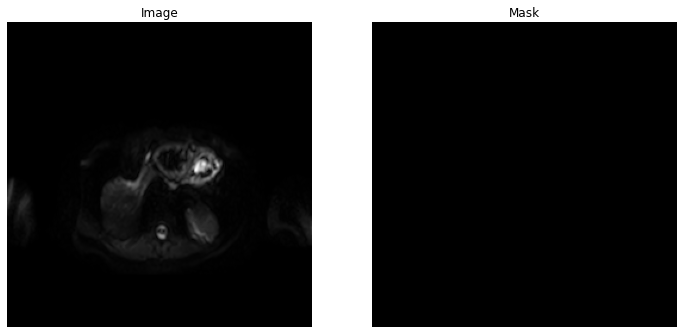

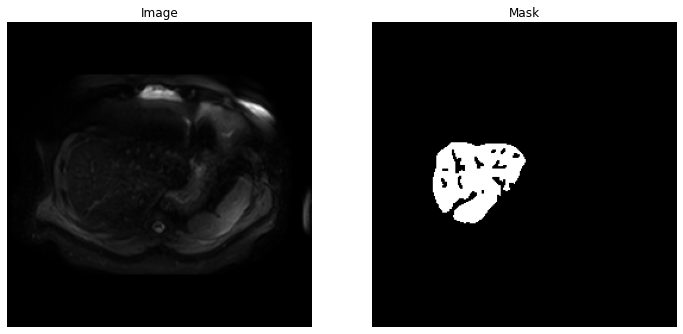

In [12]:
vis_pair(input_slice1, gt_slice1)
vis_pair(input_slice2, gt_slice2)

## Visualize a data slice and corresponding masks

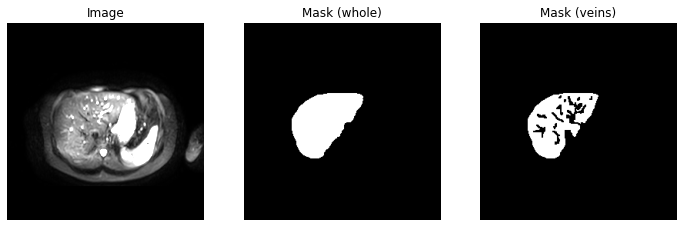

In [50]:
data = '/home/dtank/lood_storage/divi/Projects/anchor/analysis/ANCHOR_0017_V1/MR/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/x20190327_100208WIPDWIIVIMSENSE13PF07fatsatdefs901a1009.nii.gz'
mask_lever = '/home/dtank/lood_storage/divi/Projects/anchor/analysis/ANCHOR_0017_V1/MR/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/Liver2.nii.gz'
mask_vaten = '/home/dtank/lood_storage/divi/Projects/anchor/analysis/ANCHOR_0017_V1/MR/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/00901_DWI-IVIM_SENSE13_PF07_fatsatdef/Liver.nii.gz'

pairname_lever = [data, mask_lever]
pairname_vaten = [data, mask_vaten]

pair_lever = SegmentationPair2D(pairname_lever[0], pairname_lever[1])
pair_vaten = SegmentationPair2D(pairname_vaten[0], pairname_vaten[1])

slice_pair_lever = pair_lever.get_pair_slice(13)
inputlever = slice_pair_lever['input']
gtlever = slice_pair_lever['gt']

slice_pair_vaten = pair_vaten.get_pair_slice(13)
gtvaten = slice_pair_vaten['gt']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,6))
input_slice = ndimage.rotate(inputlever, 90)
ax1.imshow(input_slice, cmap='gray', vmin=0, vmax=400)
ax1.set_title('Image')
ax1.axis('off')

gt_slice_liver = ndimage.rotate(gtlever, 90)
ax2.imshow(gt_slice_liver, cmap='gray')
ax2.set_title('Mask (whole)')
ax2.axis('off')

gt_slice_vaten = ndimage.rotate(gtvaten, 90)
ax3.imshow(gt_slice_vaten, cmap='gray')
ax3.set_title('Mask (veins)')
ax3.axis('off')

plt.show()

# Visualize a batch

In [51]:
CONFIG_PATH = '../src/config.yaml'
config = load_config(CONFIG_PATH)

train_transforms = torchvision.transforms.Compose([
            mt_transforms.RandomRotation(config['train_dataloader']['data_aug']['rot_degree']), # random rotation
            mt_transforms.RandomAffine(0, translate=config['train_dataloader']['data_aug']['transl_range']), # shift
            mt_transforms.RandomAffine(0, shear=config['train_dataloader']['data_aug']['shear_range']), # shear
            HistogramClipping(),
            RangeNorm(),
            mt_transforms.ToTensor(),
        ])

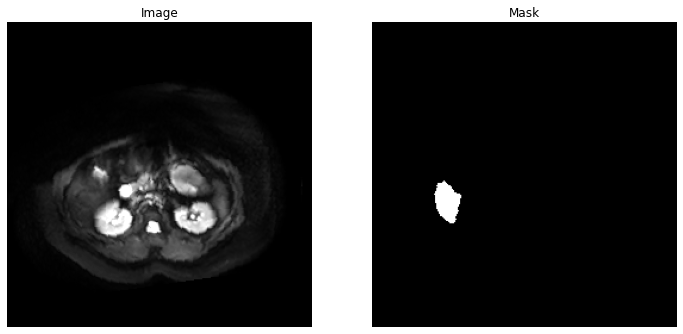

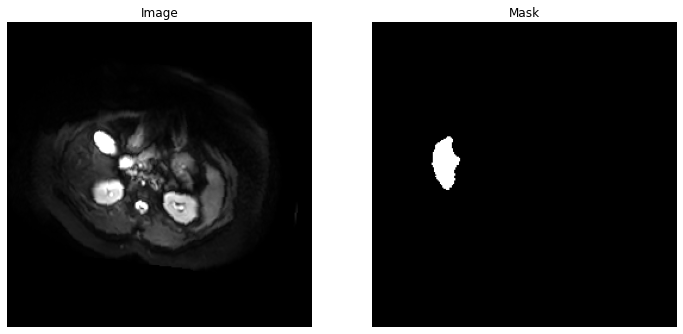

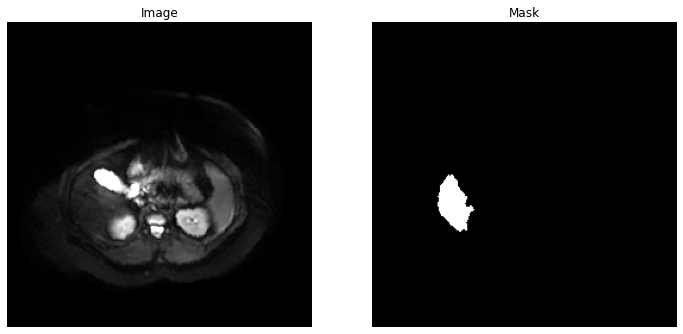

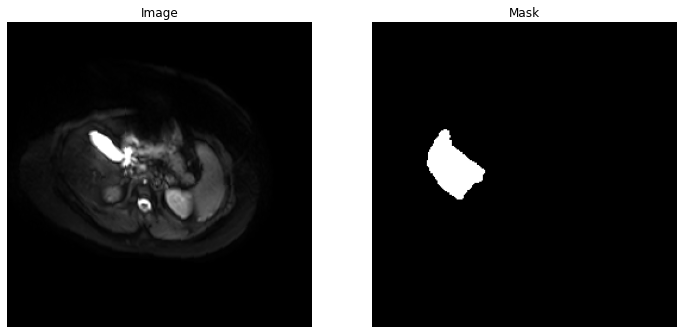

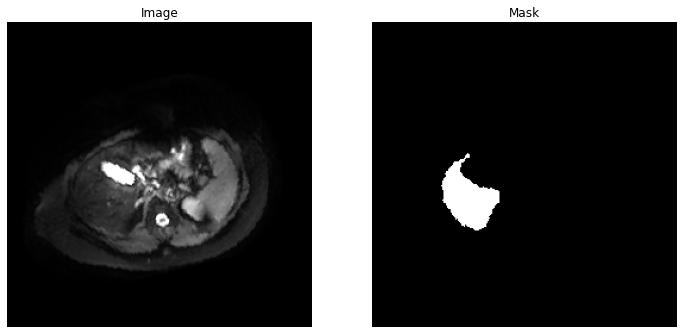

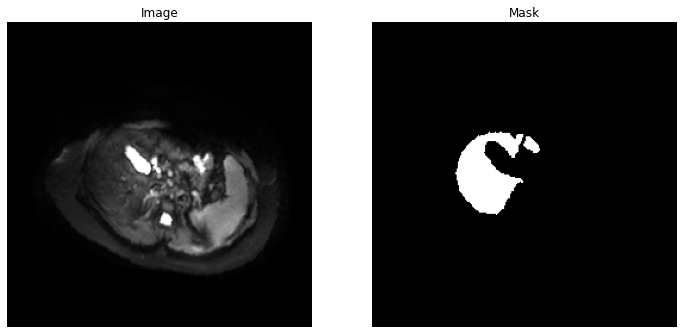

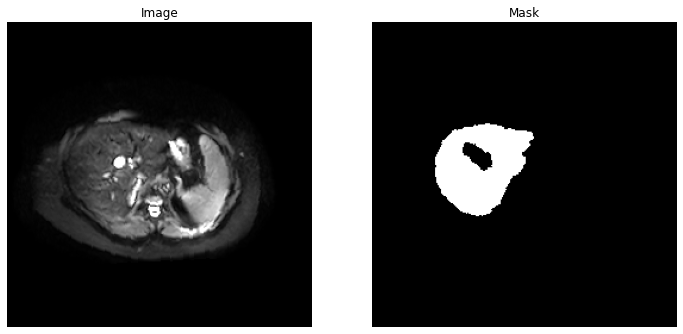

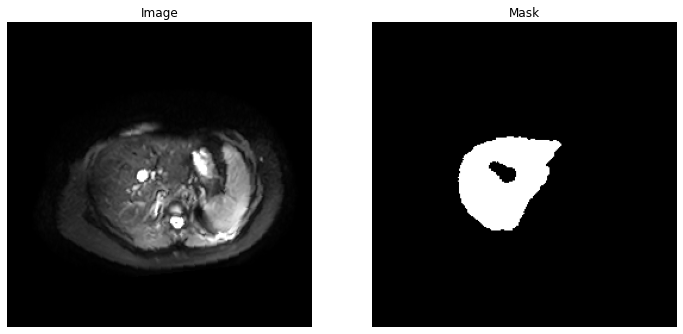

In [52]:
dataset = MRI2DSegmentationDataset(filename_pairs[:5],transform=train_transforms, slice_filter_fn=slice_filtering,)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=mt_datasets.mt_collate)

vis_batch(dataloader)

# Cover Page | Costumizable Grid image

In [53]:
# grid van 10 liver images en daaronder 10 corresponderende mask images --> 10x10 grid
pair1 = filename_pairs[30] 
pair1 = SegmentationPair2D(pair1[0], pair1[1])

image_slices = []

for i in range(10):
    image_slices.append(pair1.get_pair_slice(i+5)['input'])
for i in range(10):    
    image_slices.append(pair1.get_pair_slice(i+5)['gt'])

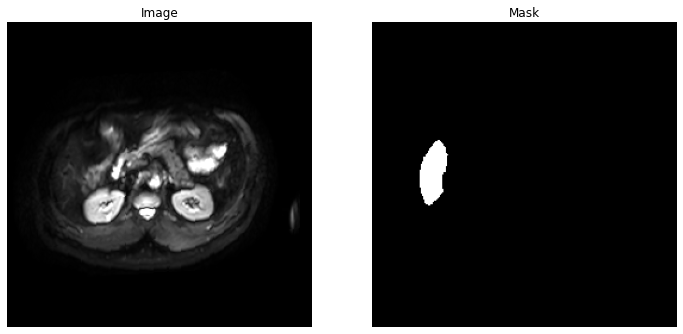

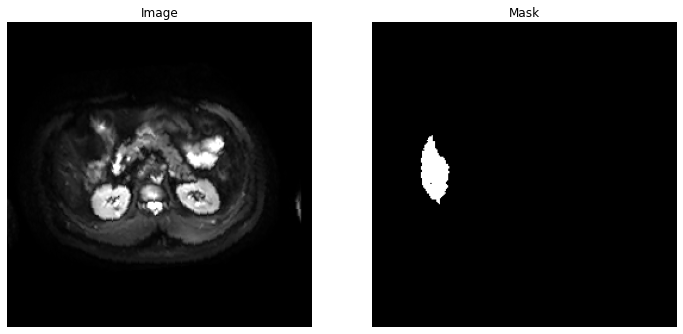

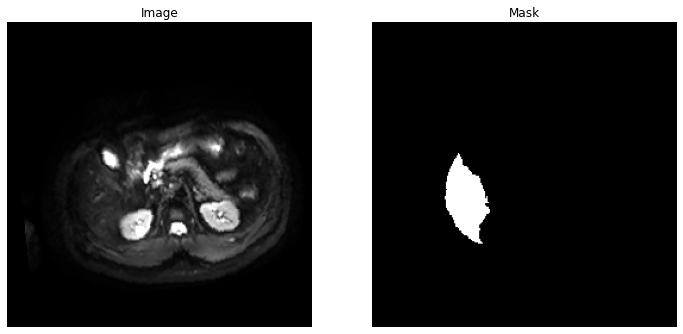

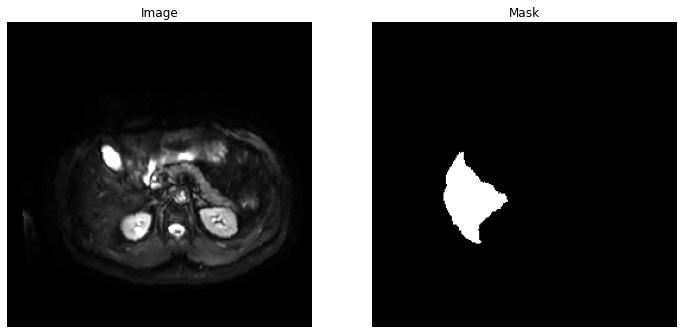

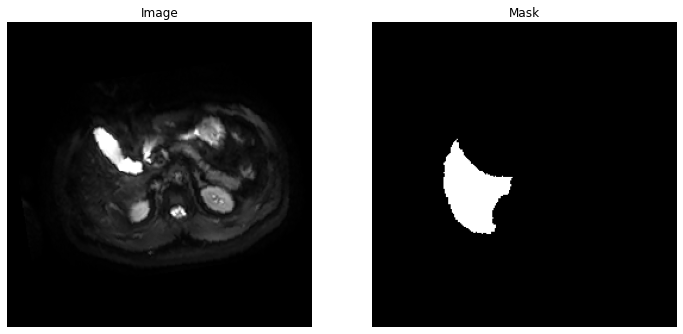

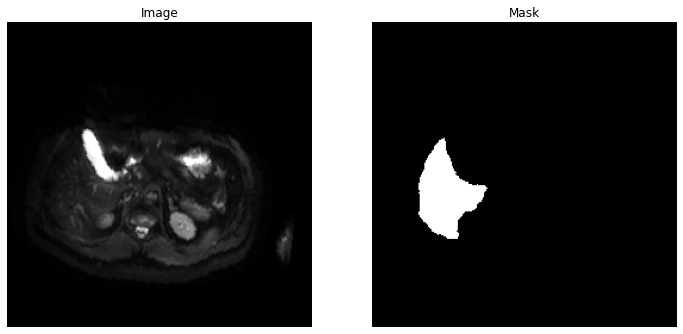

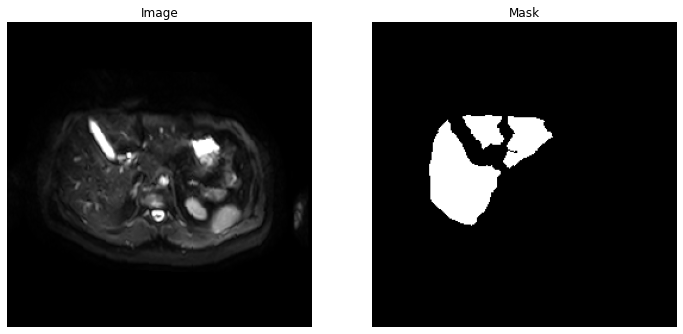

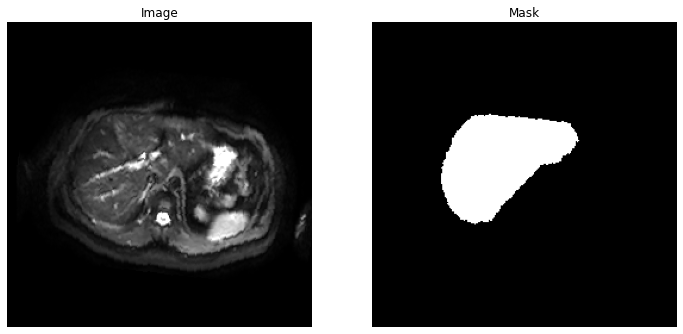

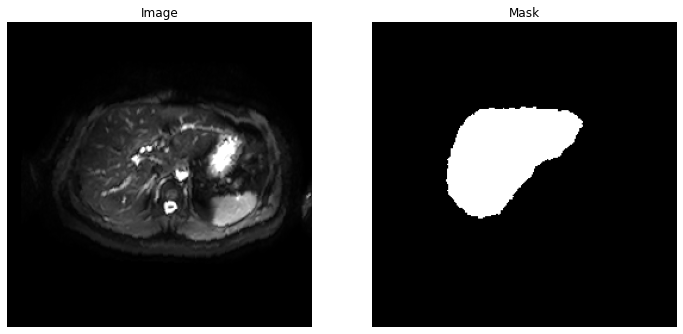

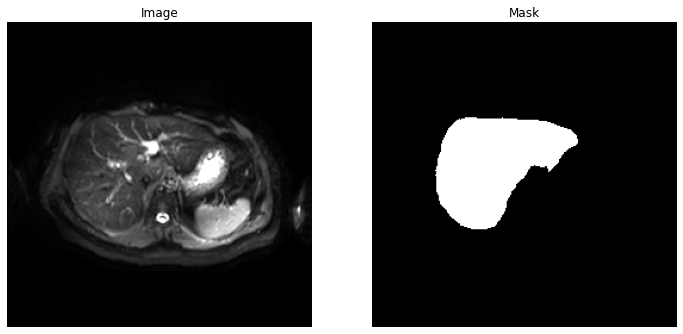

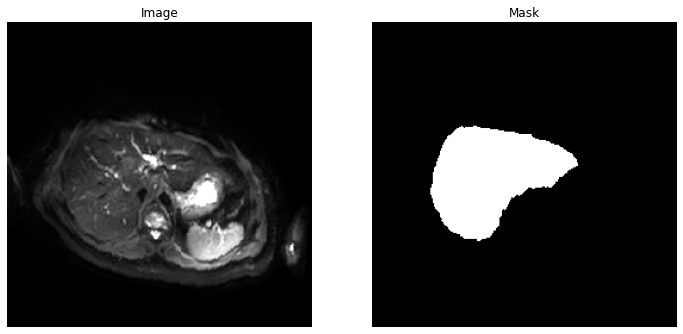

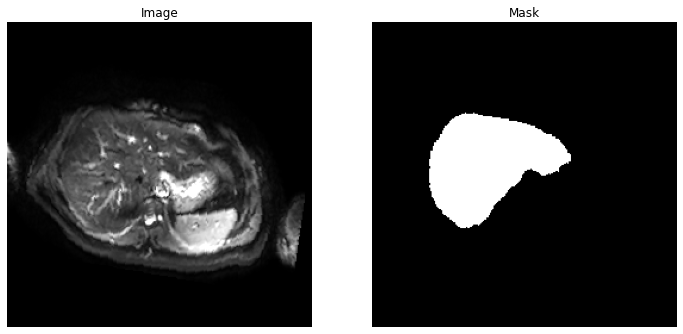

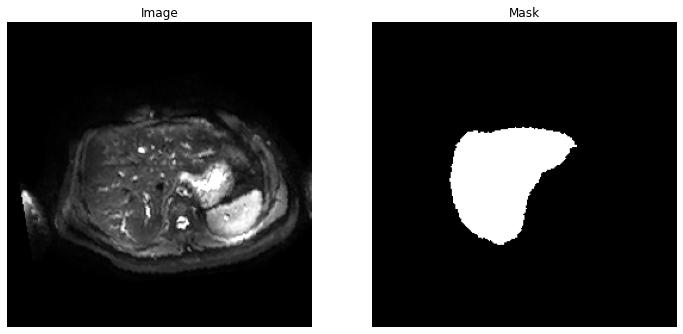

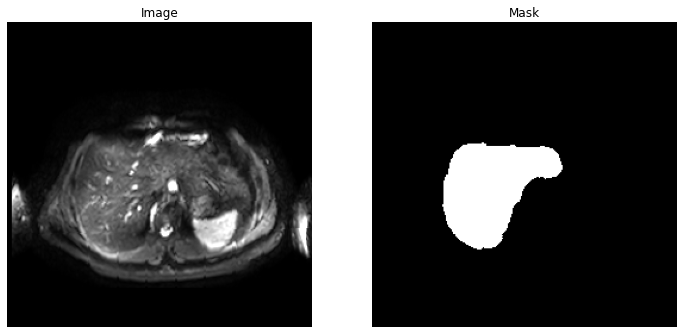

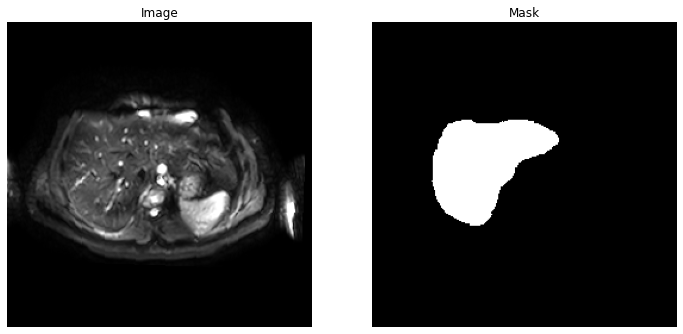

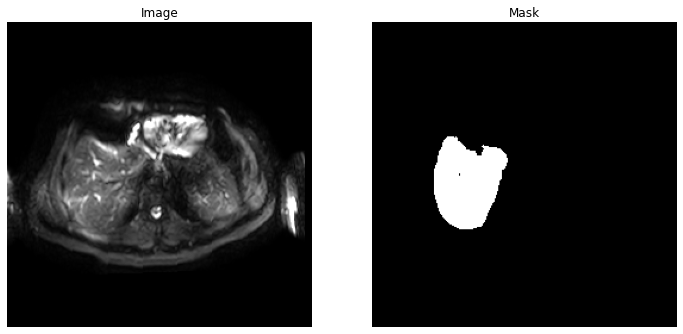

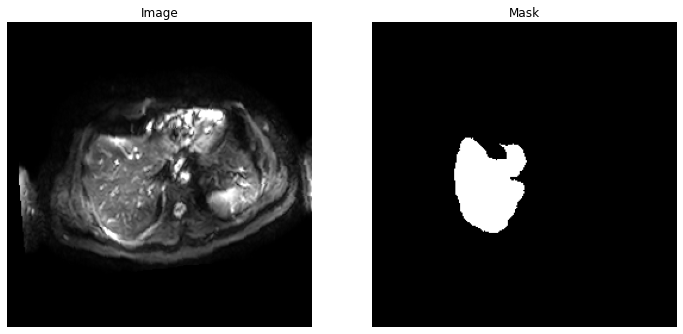

In [54]:
# Includes augmentations
dataset = MRI2DSegmentationDataset([filename_pairs[30]],transform=train_transforms, slice_filter_fn=slice_filtering,)
dataloader = DataLoader(dataset, batch_size=20, shuffle=False, collate_fn=mt_datasets.mt_collate)

vis_batch(dataloader)

In [55]:
# Includes augmentations
for batch in dataloader:
    images, labels = batch['input'], batch['gt']
    
image_slices = []

for i in range(10):
    image_slices.append(images[i].squeeze(0))
for i in range(10):
    image_slices.append(labels[i].squeeze(0))

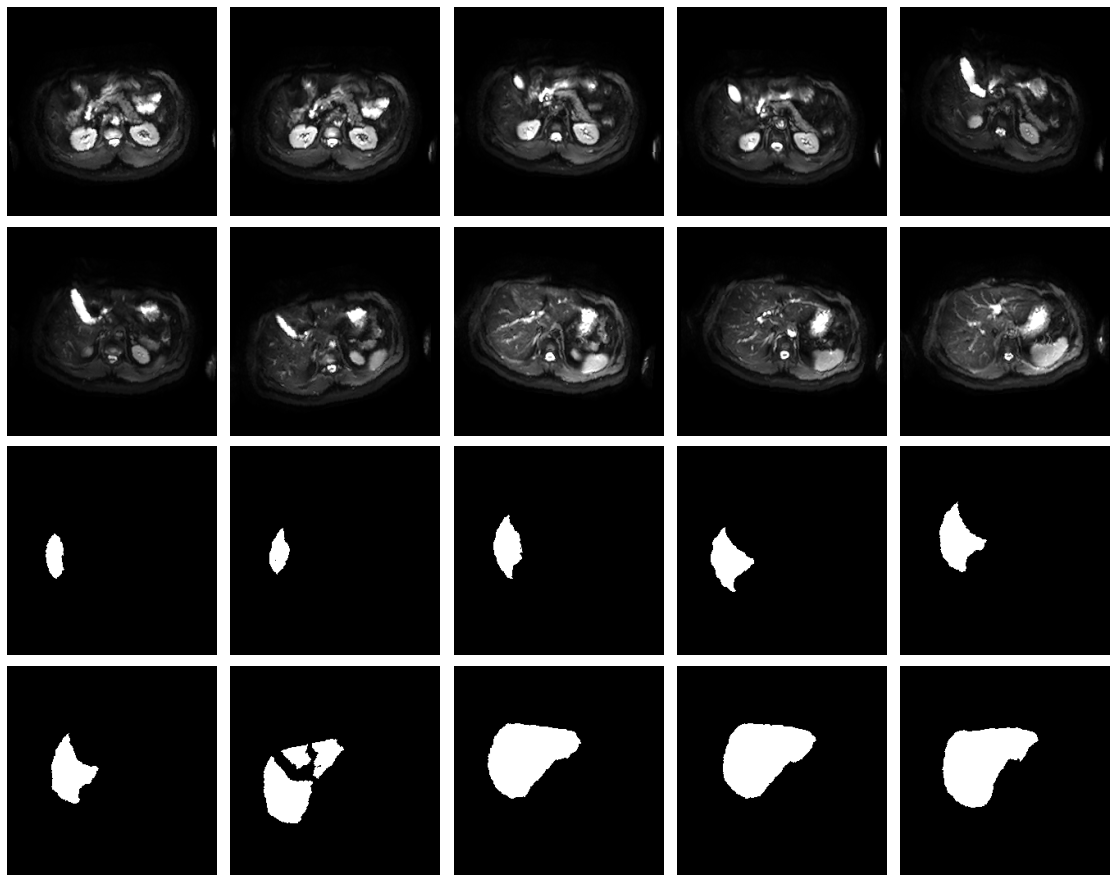

In [56]:
plt.figure(figsize=(20,20)) # specifying the overall grid size

for i in range(20):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    image_slice = ndimage.rotate(image_slices[i], 90)
    plt.imshow(image_slice, cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.05)

# plt.savefig('coverpage.png')
plt.show()

# Load model and visualize predictions

In [3]:
from medicaltorch import models as mt_models
from transforms import *
from datasets import *
import torch

In [4]:
from sklearn.model_selection import KFold
CONFIG_PATH = '/home/dtank/scratch/AutoLiverSeg/src/config.yaml'
config = load_config(CONFIG_PATH)
    
kfold = KFold(n_splits=config['model_params']['k_folds'], 
                  shuffle=True, random_state=config['model_params']['random_state'])

for fold, (train_index, test_index) in enumerate(kfold.split(filename_pairs)):
    print(fold)
    print('train', train_index)
    print('test', test_index)
    print()

0
train [ 0  1  2  4  6  7  8  9 10 11 14 15 16 18 20 21 22 23 24 25 26 27 28 29
 30 31 33 34 35 36 37 38 39 40 42 44 45 46 48 49 51 52]
test [ 3  5 12 13 17 19 32 41 43 47 50]

1
train [ 0  1  2  3  5  7  9 10 11 12 13 14 16 17 18 19 20 21 22 23 25 27 28 29
 30 31 32 35 36 38 39 40 41 42 43 45 46 47 48 50 51 52]
test [ 4  6  8 15 24 26 33 34 37 44 49]

2
train [ 1  2  3  4  5  6  7  8 10 12 13 14 15 17 18 19 20 21 22 23 24 26 28 29
 32 33 34 35 37 38 40 41 42 43 44 45 47 48 49 50 51 52]
test [ 0  9 11 16 25 27 30 31 36 39 46]

3
train [ 0  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 22 24 25 26 27 28
 30 31 32 33 34 36 37 38 39 41 42 43 44 46 47 49 50 51 52]
test [ 1  2 10 21 23 29 35 40 45 48]

4
train [ 0  1  2  3  4  5  6  8  9 10 11 12 13 15 16 17 19 21 23 24 25 26 27 29
 30 31 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 50]
test [ 7 14 18 20 22 28 38 42 51 52]



../src/utils/utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(file)


In [78]:
test = [filename_pairs[39]] # specify a test set

In [79]:
from models import *
# PATH = '../model/model-fold-0.pth' # put your model path here
PATH = '/home/dtank/scratch/Storage/models/unet liver1/model-fold-2.pth'

model = mt_models.Unet()
# model = SegNet(1) # uncomment for SegNet
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [80]:
def slice_filtering(slice_pair):
    if len(np.unique(slice_pair['gt'])) == 1:
        return False
    else:
        return True

In [81]:
test_val_transforms = torchvision.transforms.Compose([
                                                      HistogramClipping(),
                                                      RangeNorm(),
                                                      mt_transforms.ToTensor()])

val_dataset = MRI2DSegmentationDataset(test,
                                               transform=test_val_transforms, 
                                               slice_filter_fn=slice_filtering) 

val_dataloader = DataLoader(val_dataset, batch_size=30,collate_fn=mt_datasets.mt_collate)

In [82]:
with torch.no_grad():
    for batch in val_dataloader:
        images, labels = batch['input'], batch['gt']

        model.eval()
        pred = model(images)

/home/dtank/scratch/autosegliver/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/dtank/scratch/autosegliver/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# function to plot image, mask and prediction together 
def vis_pred(image, mask, pred):

    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,6))
        
        image = ndimage.rotate(image.squeeze(0), 90)
        ax1.imshow(image, cmap='gray')
        ax1.set_title('Image')
        ax1.axis('off')

        mask = ndimage.rotate(mask.squeeze(0), 90)
        ax2.imshow(mask, cmap='gray')
        ax2.set_title('Ground Truth')
        ax2.axis('off')

        pred = ndimage.rotate(pred.squeeze(0).squeeze(0), 90)
        ax3.imshow(pred, cmap='gray')
        ax3.set_title('Prediction')
        ax3.axis('off')
        
        plt.plot()

In [ ]:
for i in range(6):
    vis_pred(images[i], labels[i], pred[i])

In [ ]:
# function to plot image, mask, prediction and overlay together 
def overlay_pred(image, mask, pred):

    with torch.no_grad():
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12,6))
        
        image = ndimage.rotate(image.squeeze(0), 90)
        ax1.imshow(image, cmap='gray')
        ax1.set_title('Image')
        ax1.axis('off')
        
        mask = ndimage.rotate(mask.squeeze(0), 90)
        ax2.imshow(mask, cmap='gray', interpolation='none')
        ax2.set_title('Ground Truth')
        ax2.axis('off')

        pred = ndimage.rotate(pred.squeeze(0).squeeze(0), 90)
        ax3.imshow(pred, cmap='gray', interpolation='none')
        ax3.set_title('Prediction')
        ax3.axis('off')
        
        ax4.imshow(mask, cmap='gray', interpolation='none')
        ax4.imshow(pred, cmap='gray', interpolation='none', alpha=0.7)
        ax4.set_title('Overlay')
        ax4.axis('off')
        
        plt.show()

In [ ]:
for i in range(15):
    overlay_pred(images[i], labels[i], pred[i])

In [61]:
import cv2

def zero_to_nan(values):
    outer = []
    for value in values:
        value = np.round(value)
        inner = [float('nan') if x==0 else x for x in value]
        outer.append(inner)
    return outer

In [71]:
from skimage import feature

def overlay_all(image, mask, pred):

    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (30,15))
        
        image = ndimage.rotate(image.squeeze(0), 90)
        mask = ndimage.rotate(mask.squeeze(0), 90)
        pred = ndimage.rotate(pred.squeeze(0).squeeze(0), 90)
        
        edges_mask = feature.canny(mask)
        white_mask = zero_to_nan(edges_mask)
        
        edges_pred = feature.canny(pred)
        white_pred = zero_to_nan(edges_pred)
            
        ax1.imshow(image, cmap='gray')
        ax1.imshow(white_mask, cmap='cool', interpolation='none')
        ax1.set_title('Image and Ground Truth Segmentation')
        ax1.axis('off')
        
        ax2. imshow(image, cmap='gray')
        ax2.imshow(white_pred, cmap='autumn', interpolation='none')
        ax2.set_title('Prediction')
        ax2.axis('off')
        
        ax3. imshow(image, cmap='gray')
        ax3.imshow(white_mask, cmap='cool', interpolation='none')
        ax3.imshow(white_pred, cmap='autumn', interpolation='none')
        ax3.set_title('Both')
        ax3.axis('off')
        
        plt.plot(1, 1, color='cyan', label='Professional')
        plt.plot(1, 1, color='red', label='Model')
        plt.legend()
        
        plt.show()

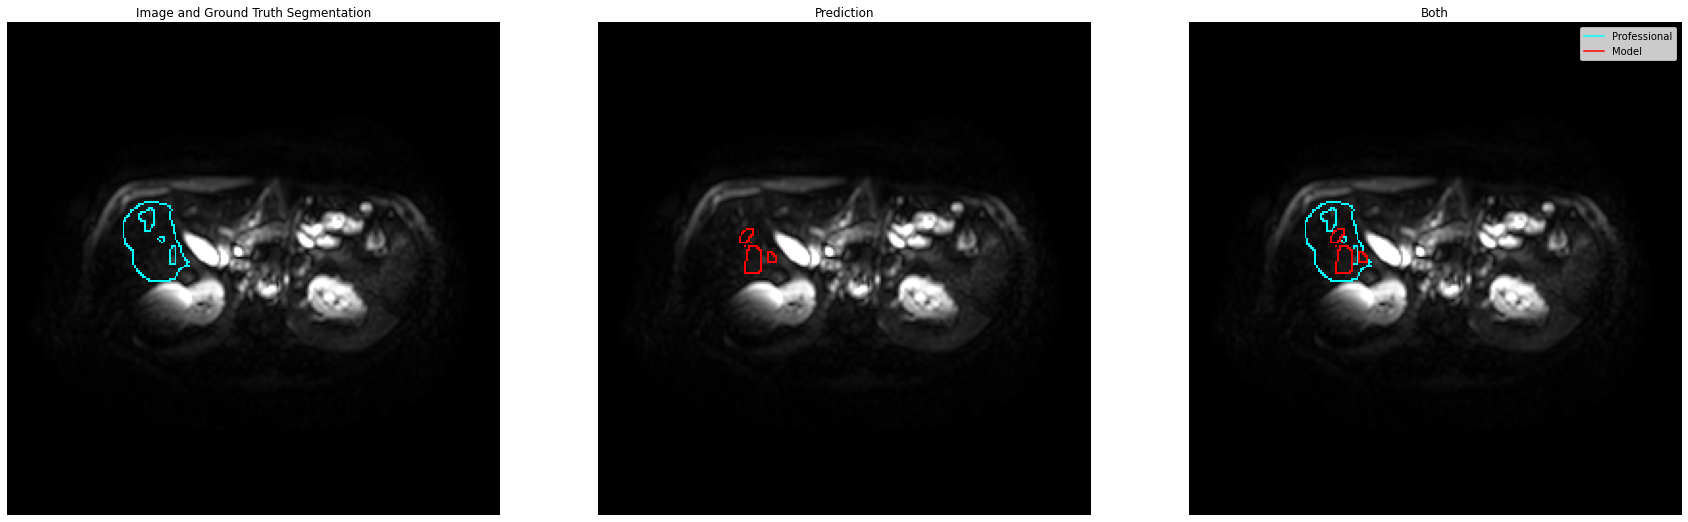

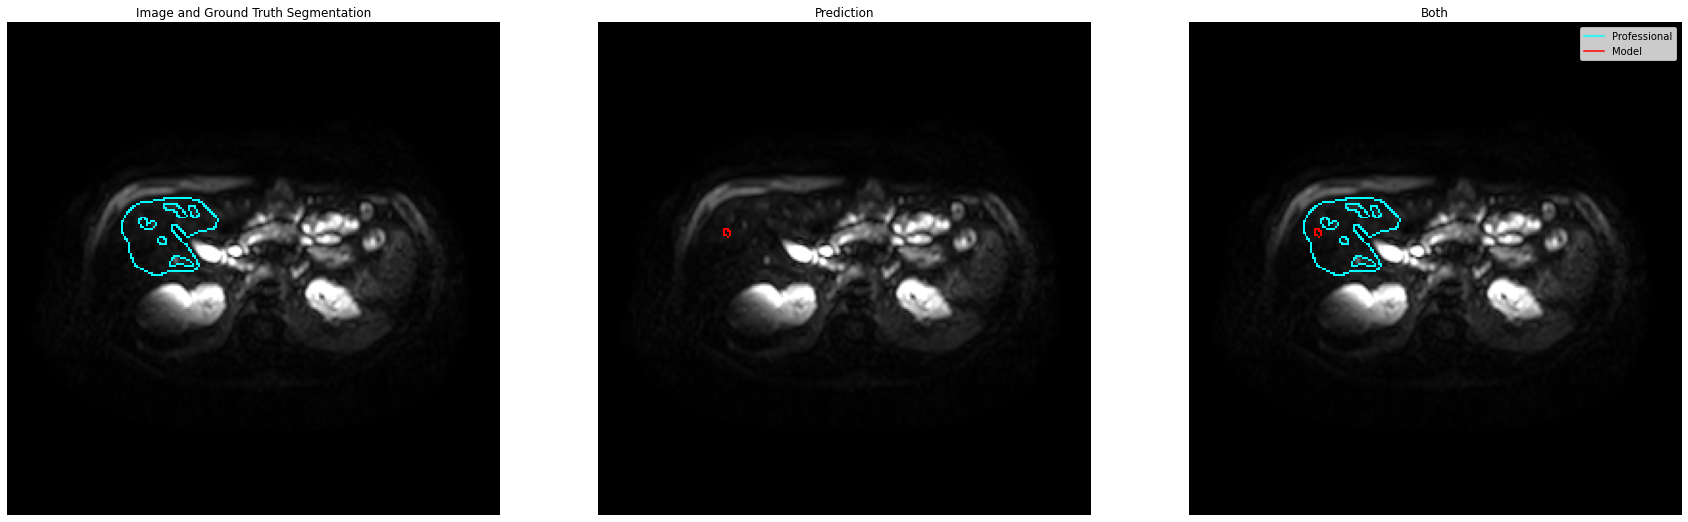

/home/dtank/scratch/autosegliver/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/dtank/scratch/autosegliver/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


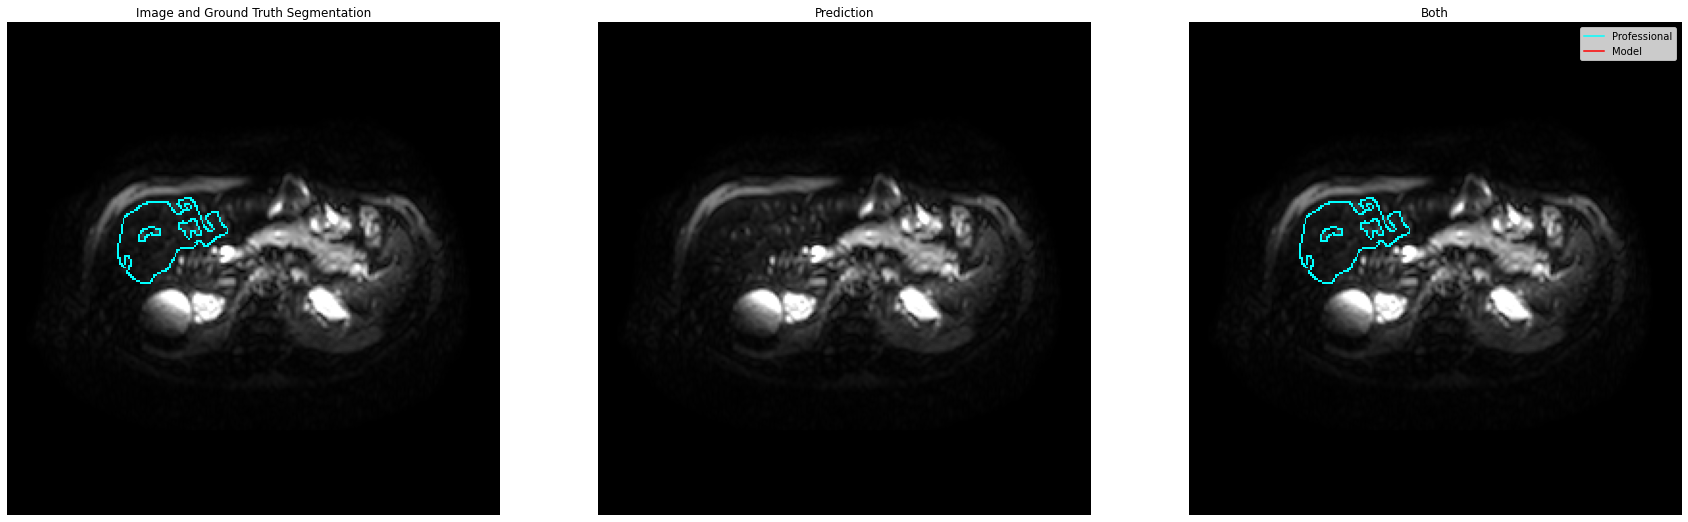

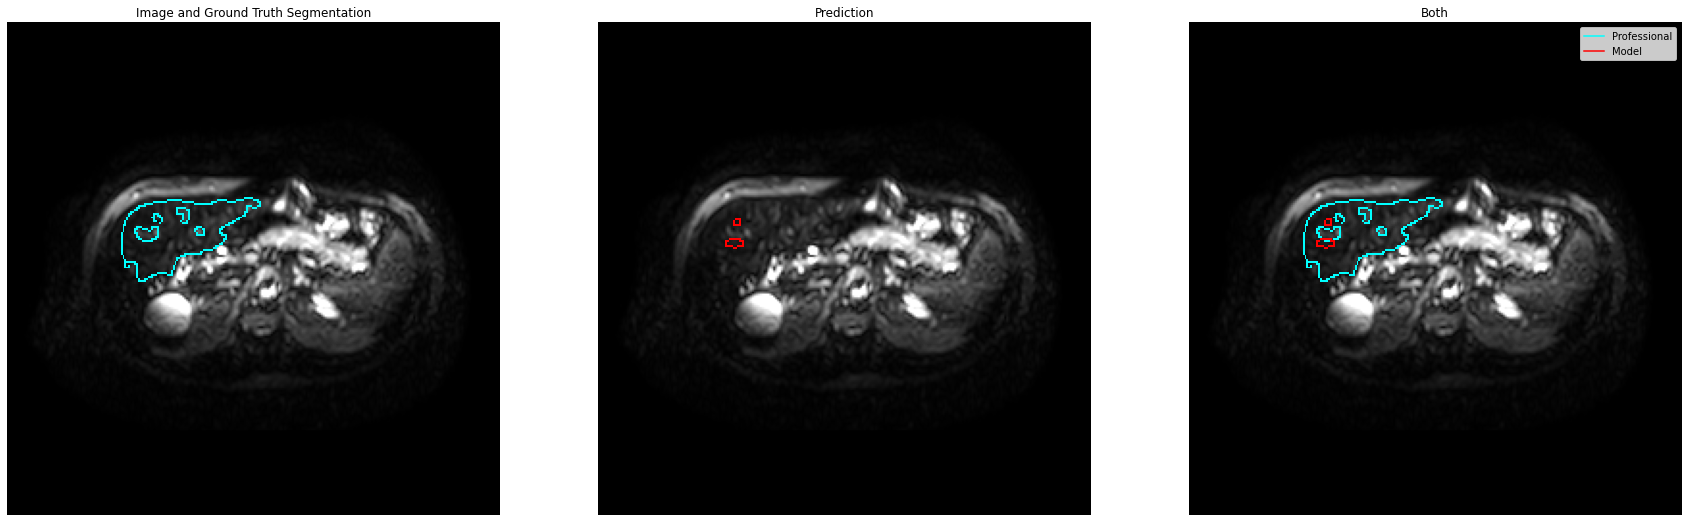

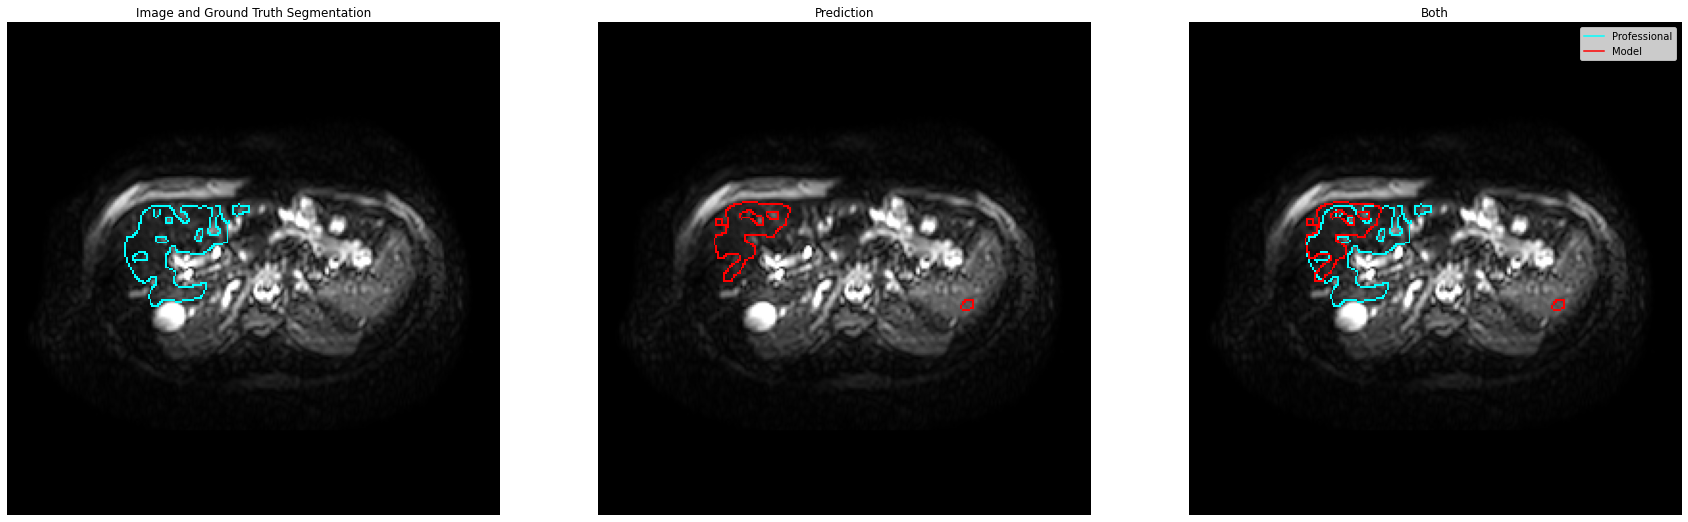

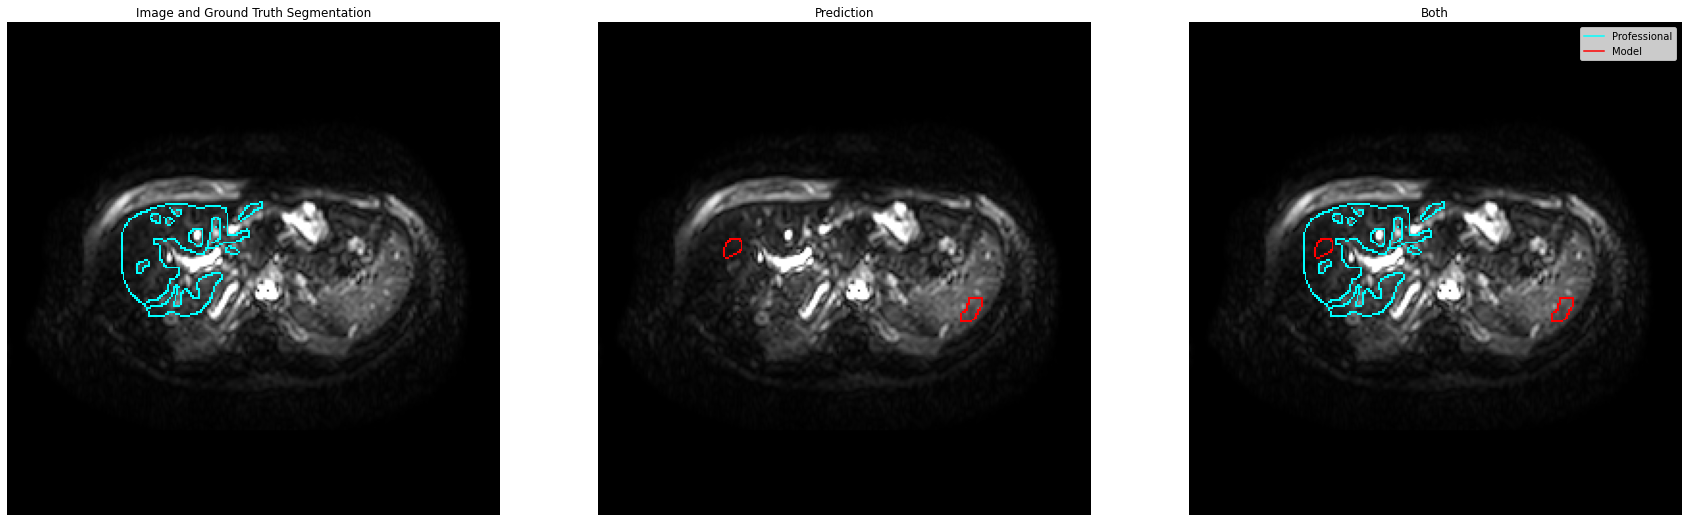

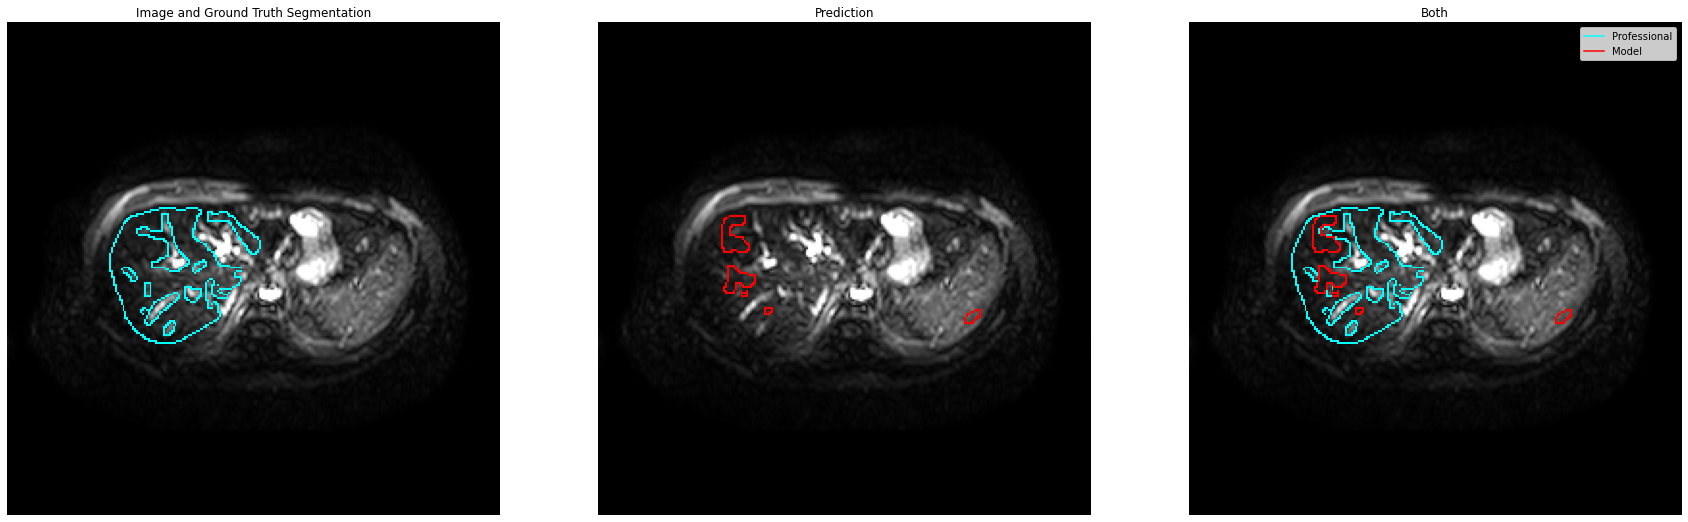

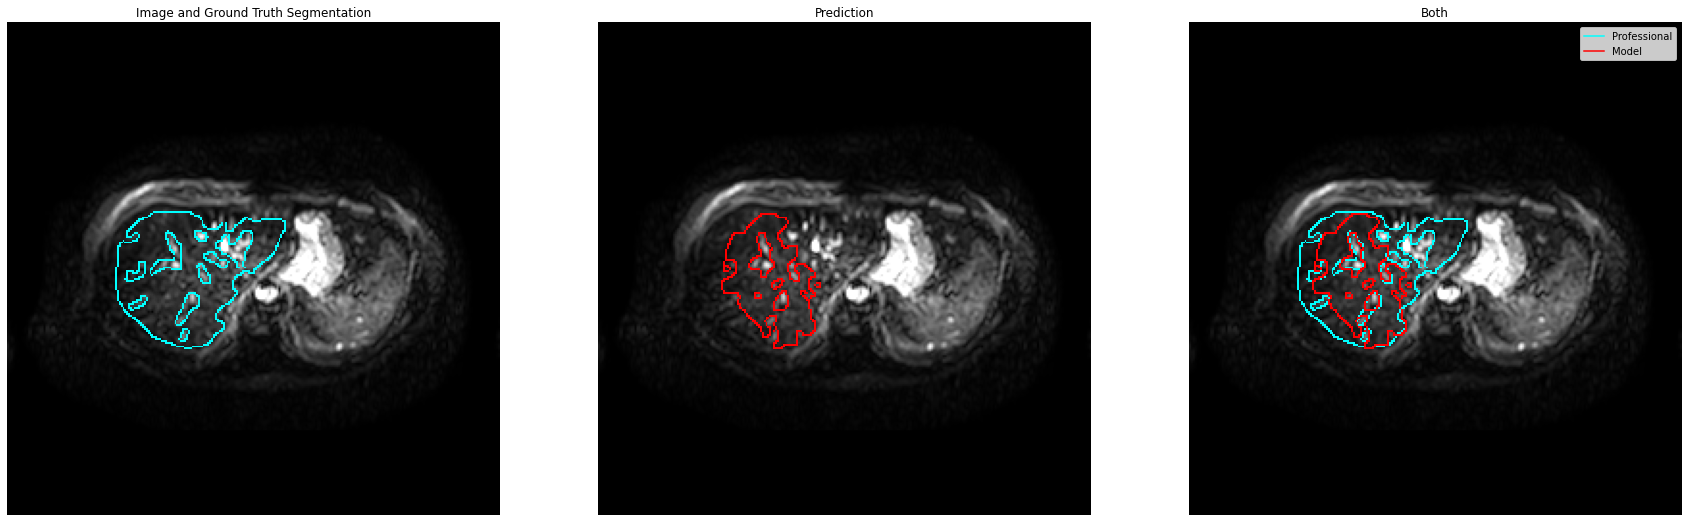

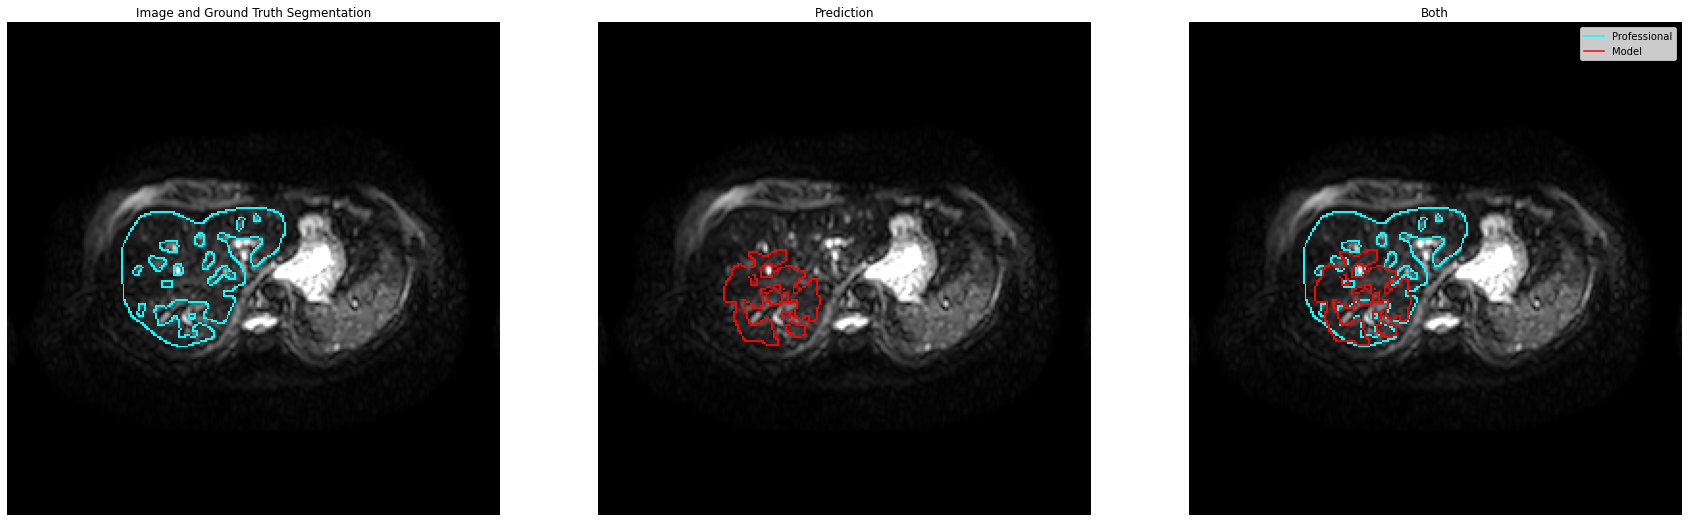

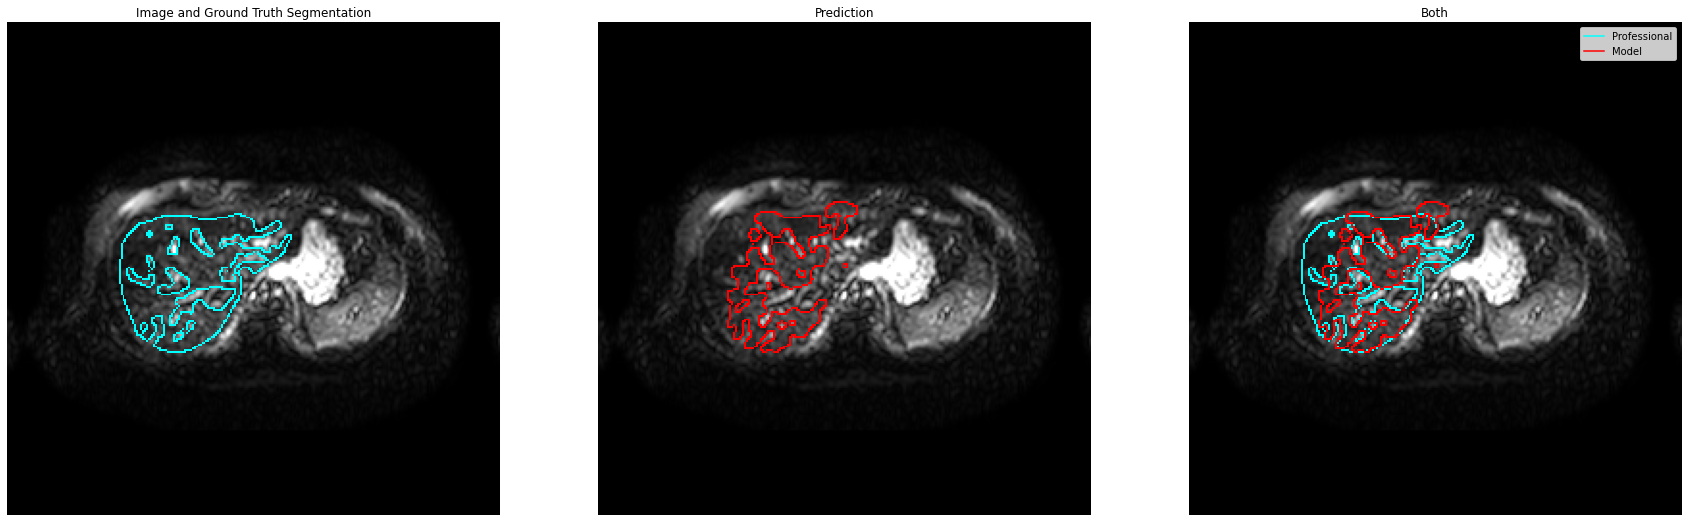

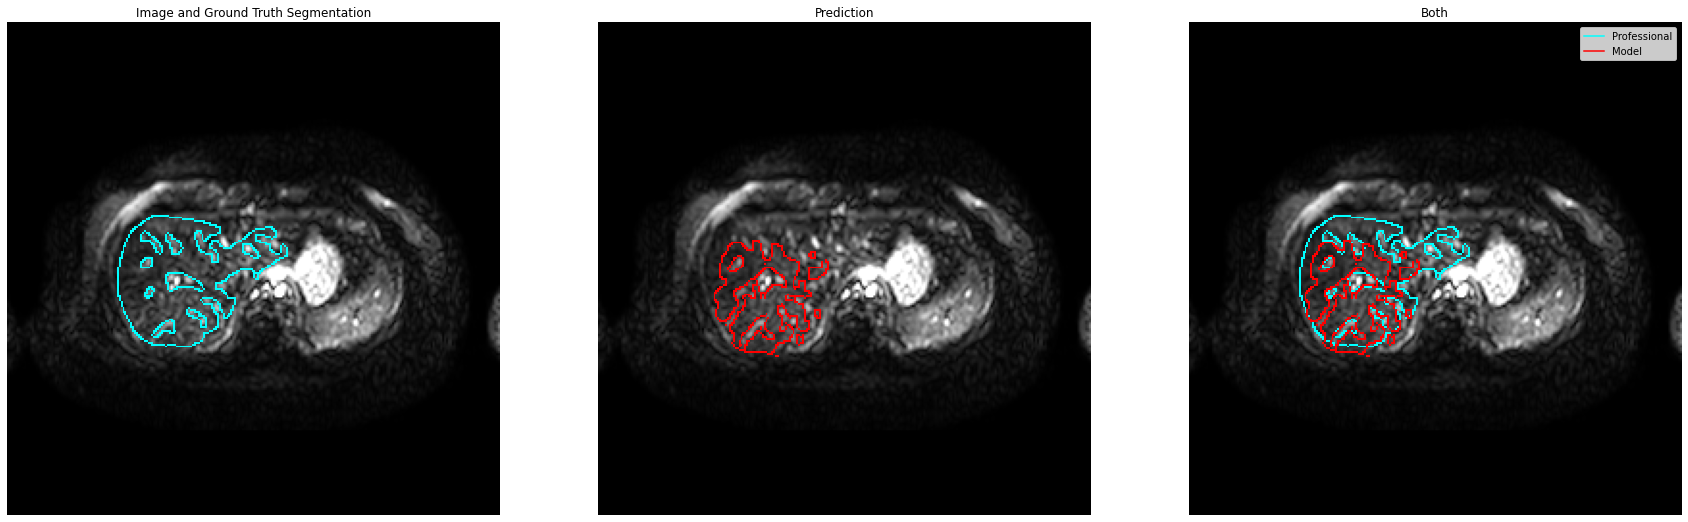

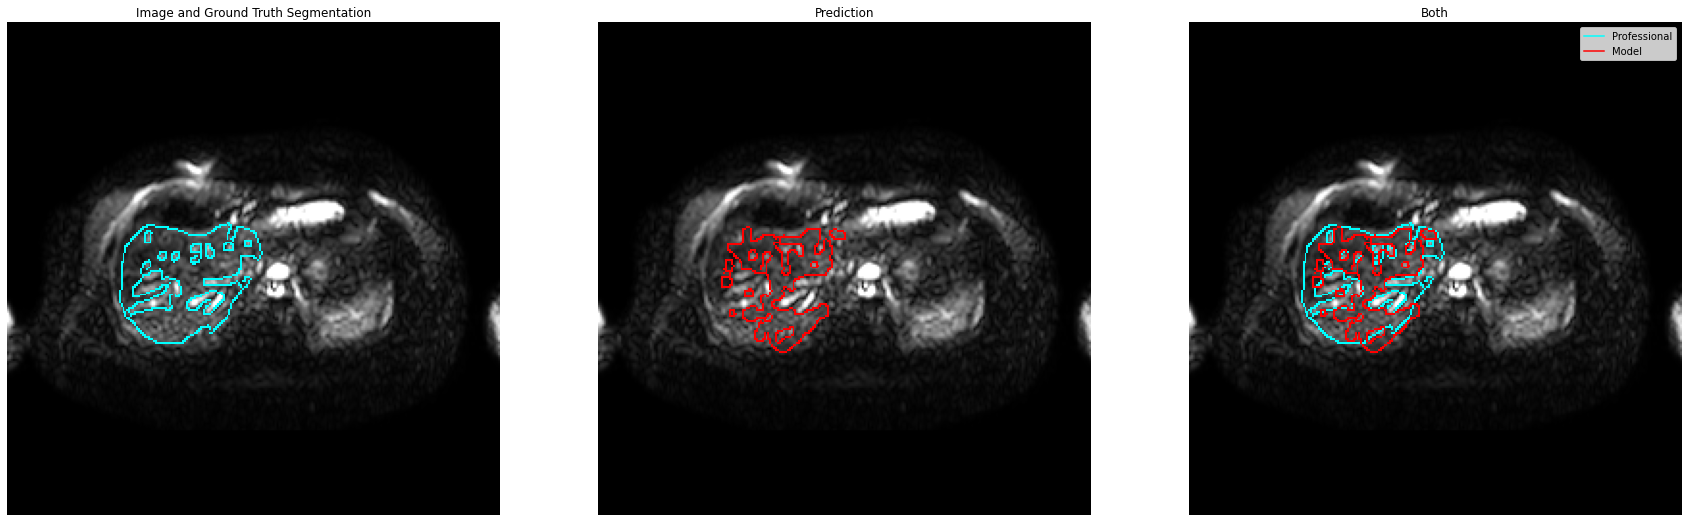

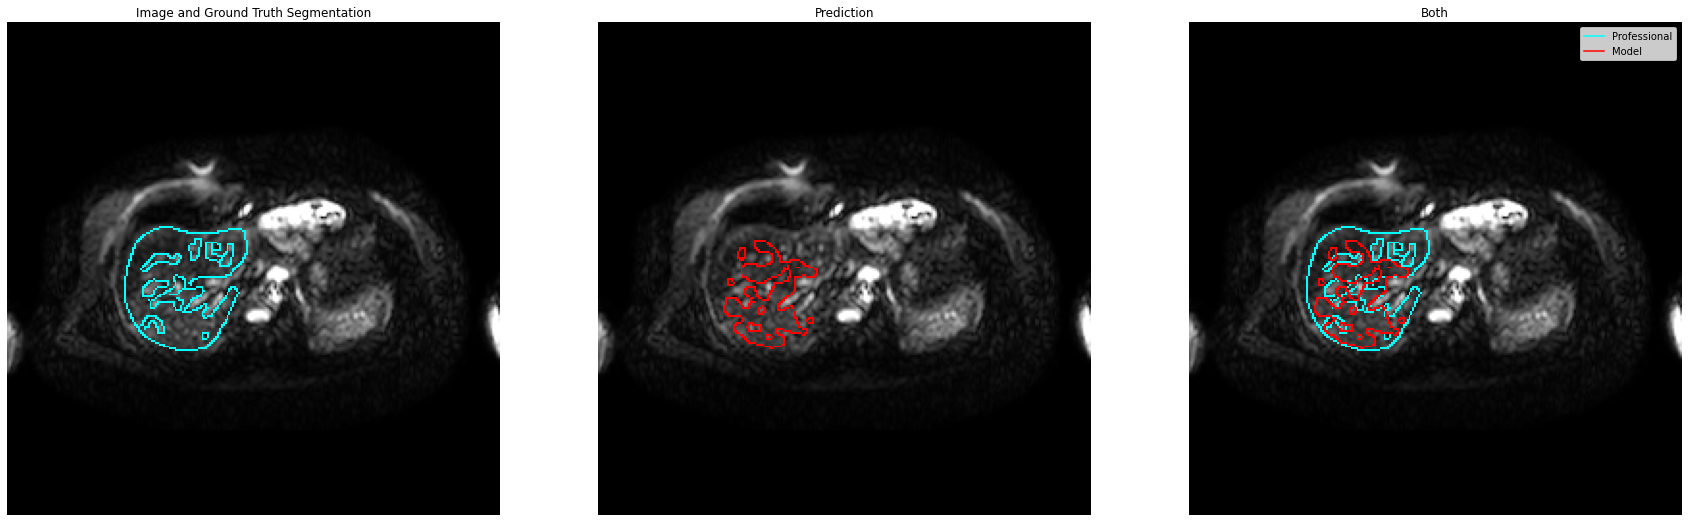

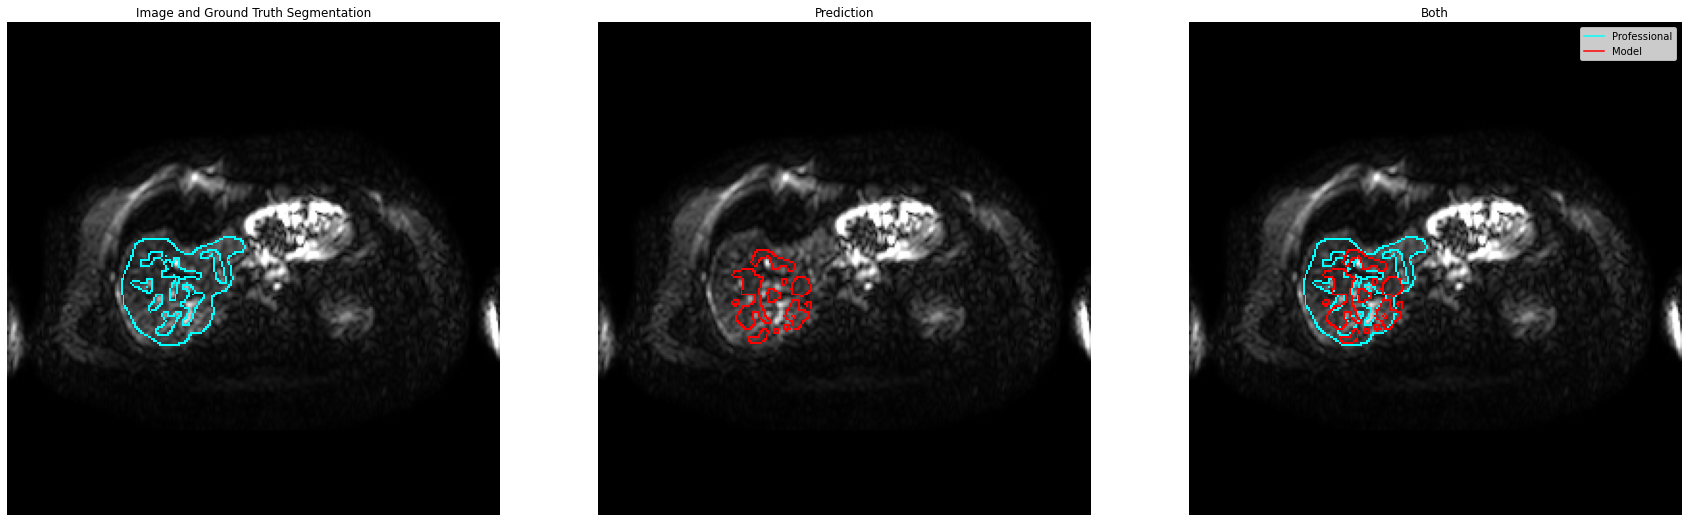

IndexError: index 14 is out of bounds for dimension 0 with size 14

In [83]:
for i in range(15):
    overlay_all(images[i], labels[i], pred[i])

In [55]:
from skimage import feature

def overlay_all(image, mask, pred):

    with torch.no_grad():
        fig, (ax1) = plt.subplots(1,1, figsize = (10,5))
        
        image = ndimage.rotate(image.squeeze(0), 90)
        mask = ndimage.rotate(mask.squeeze(0), 90)
        pred = ndimage.rotate(pred.squeeze(0).squeeze(0), 90)
        
        edges_mask = feature.canny(mask)
        white_mask = zero_to_nan(edges_mask)
        
        edges_pred = feature.canny(pred)
        white_pred = zero_to_nan(edges_pred)
        
        ax1.imshow(image, cmap='gray')
        ax1.imshow(white_mask, cmap='cool', interpolation='none')
        ax1.imshow(white_pred, cmap='autumn', interpolation='none')
        ax1.set_title('Expert v.s. Model segmentation')
        ax1.axis('off')
        
        plt.plot(1, 1, color='cyan', label='Expert')
        plt.plot(1, 1, color='red', label='Model')
        plt.legend()
        
        plt.show()

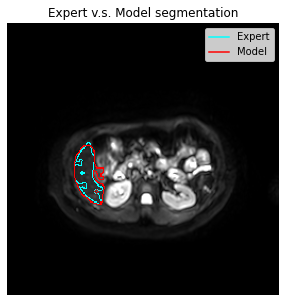

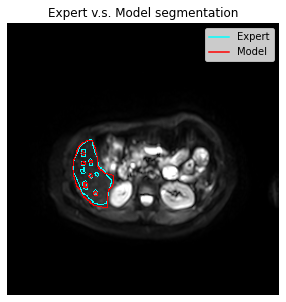

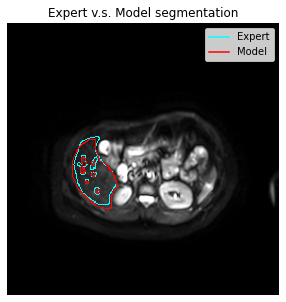

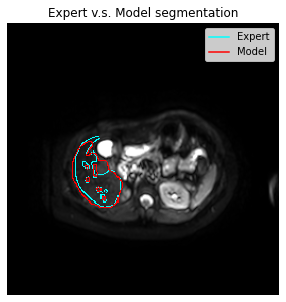

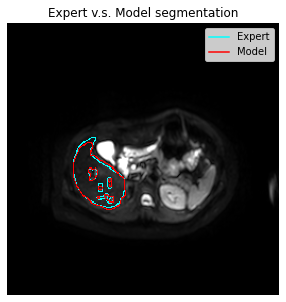

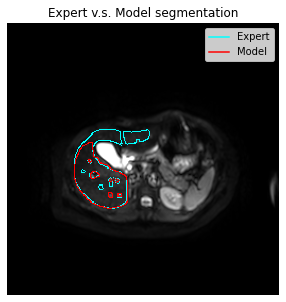

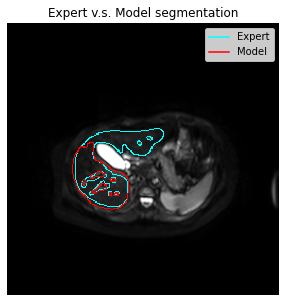

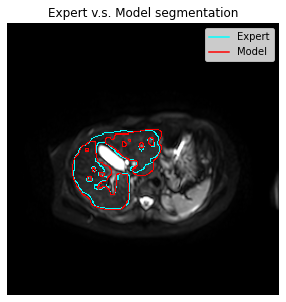

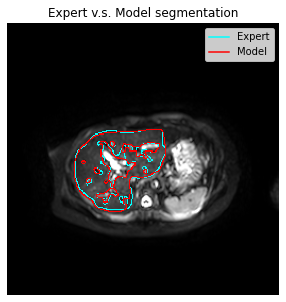

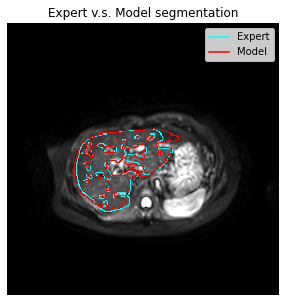

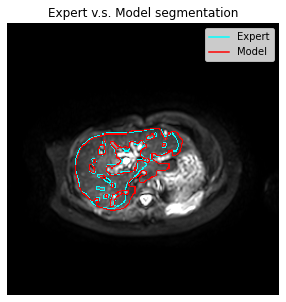

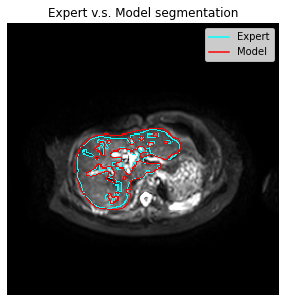

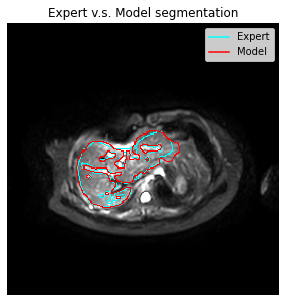

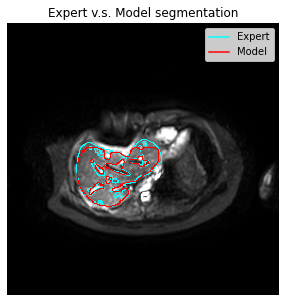

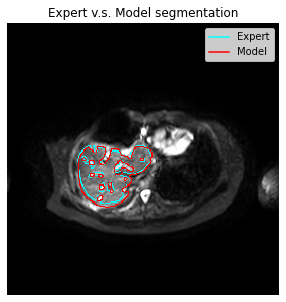

In [56]:
for i in range(15):
    overlay_all(images[i], labels[i], pred[i])

In [72]:
from skimage import feature

def show_dil(image, mask, pred):

    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (30,15))
        
        image = ndimage.rotate(image.squeeze(0), 90)
        pred = ndimage.rotate(pred.squeeze(0).squeeze(0), 90)
        
        edges_pred = feature.canny(pred)
        white_pred = zero_to_nan(edges_pred)
            
        ax1.imshow(pred, cmap='gray')
        ax1.set_title('Prediction')
        ax1.axis('off')
        
        ax2.imshow(edges_pred, cmap='gray', interpolation='none')
        ax2.set_title('Delineated Prediction')
        ax2.axis('off')
        
        ax3. imshow(image, cmap='gray')
        ax3.imshow(white_pred, cmap='binary', interpolation='none')
        ax3.set_title('Overlap')
        ax3.axis('off')
        
        plt.show()

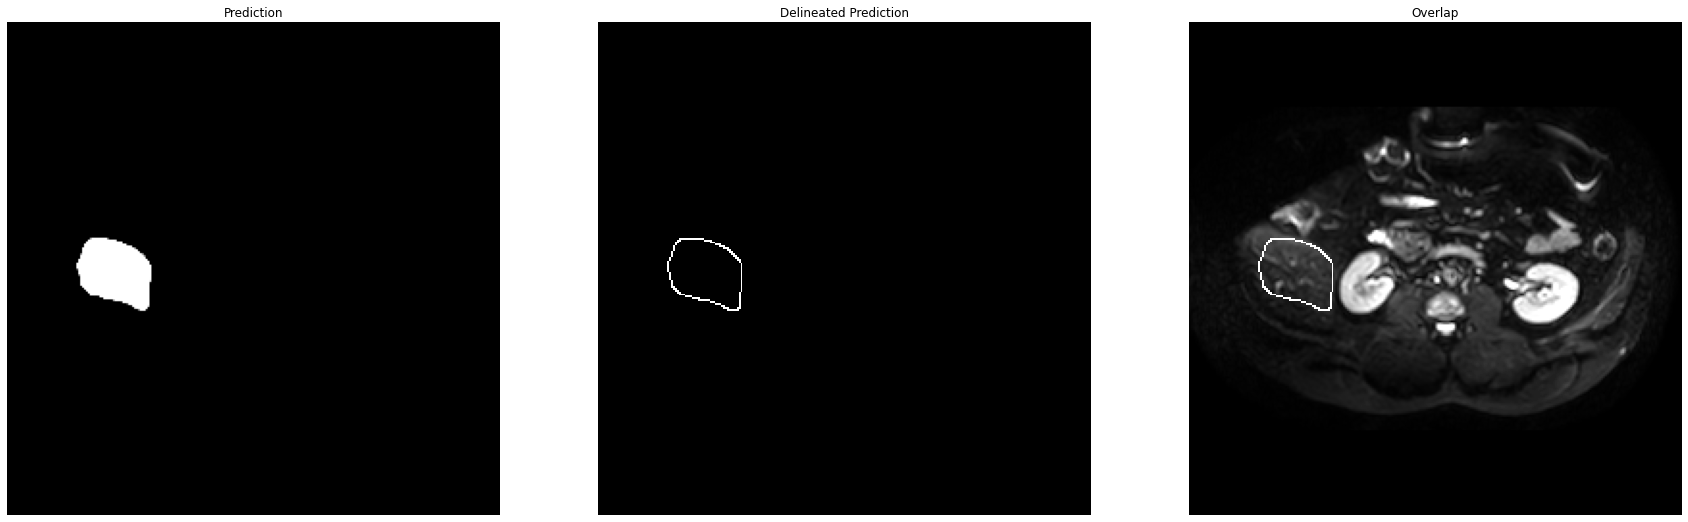

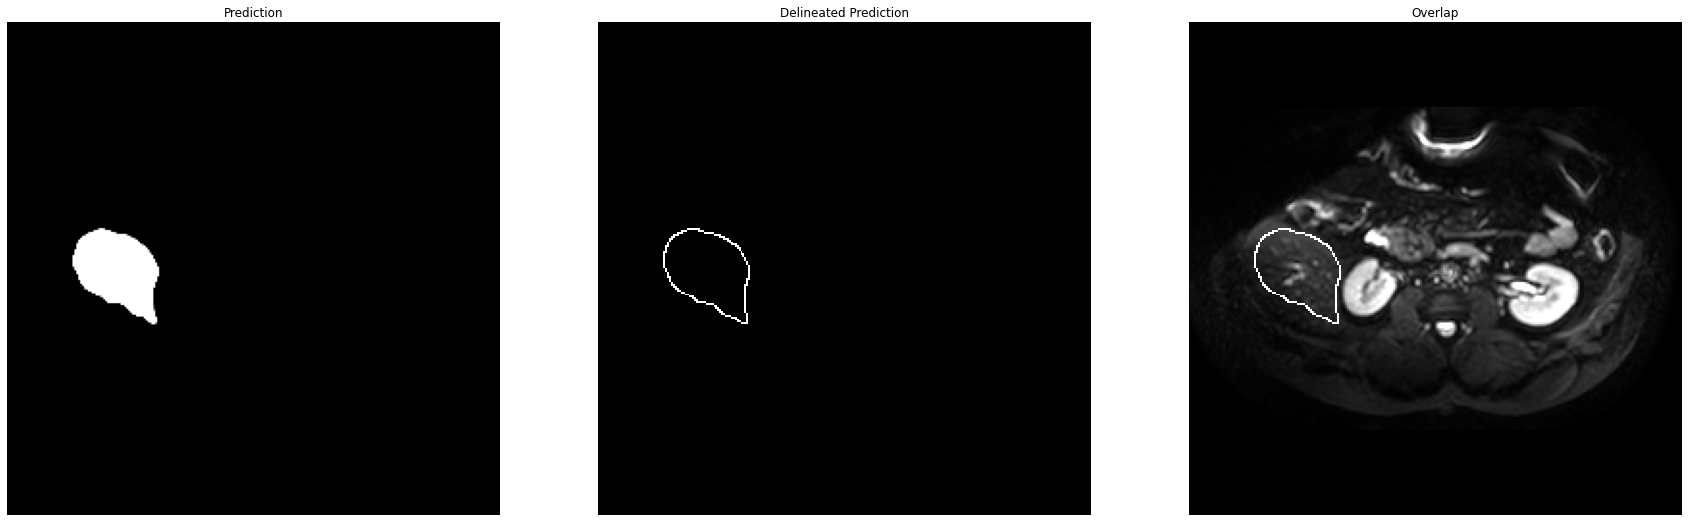

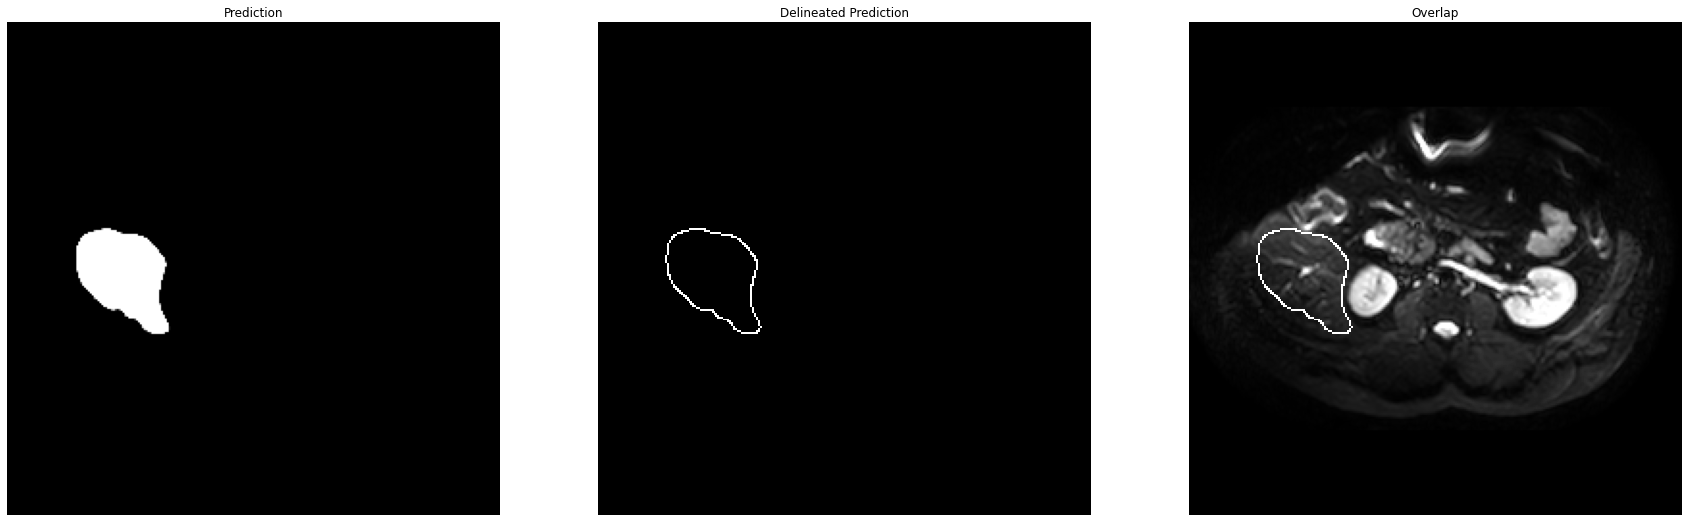

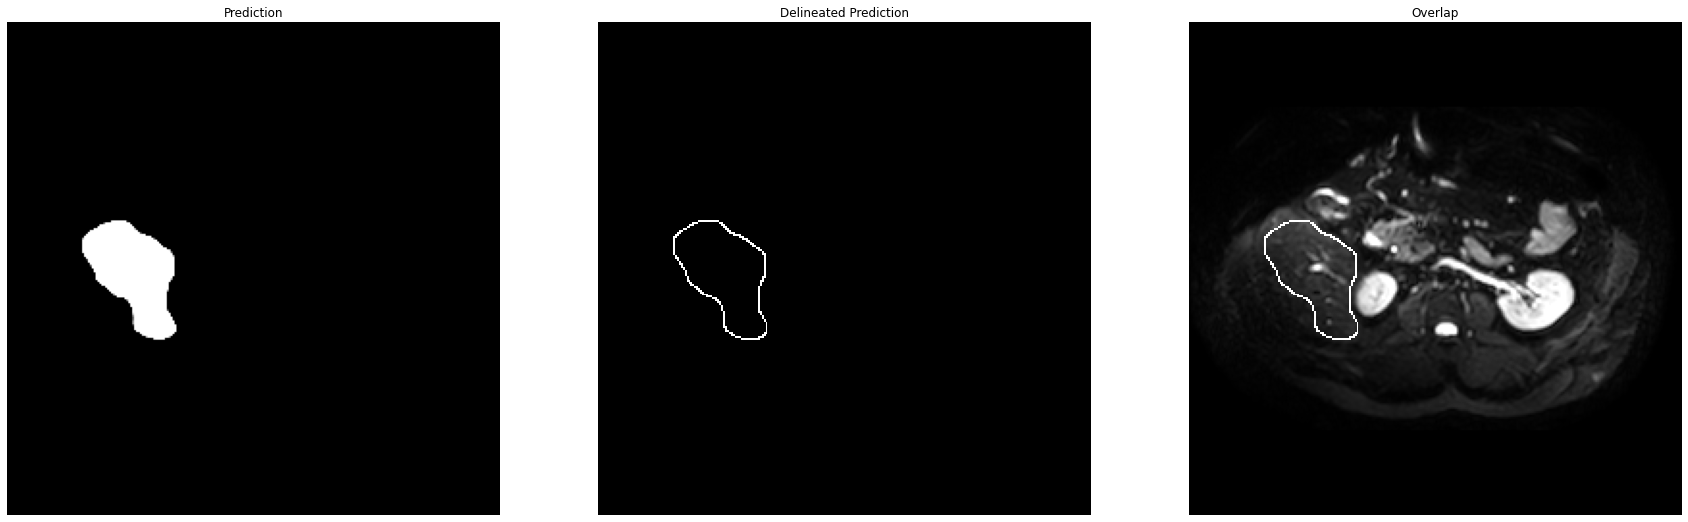

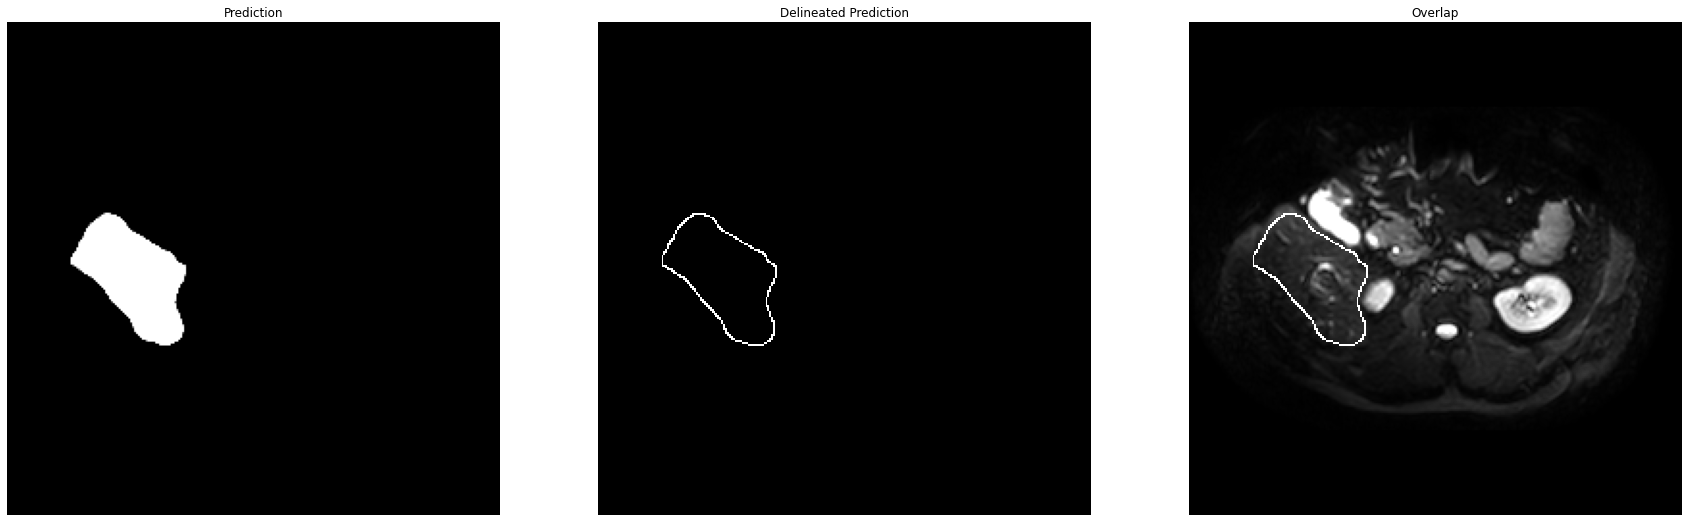

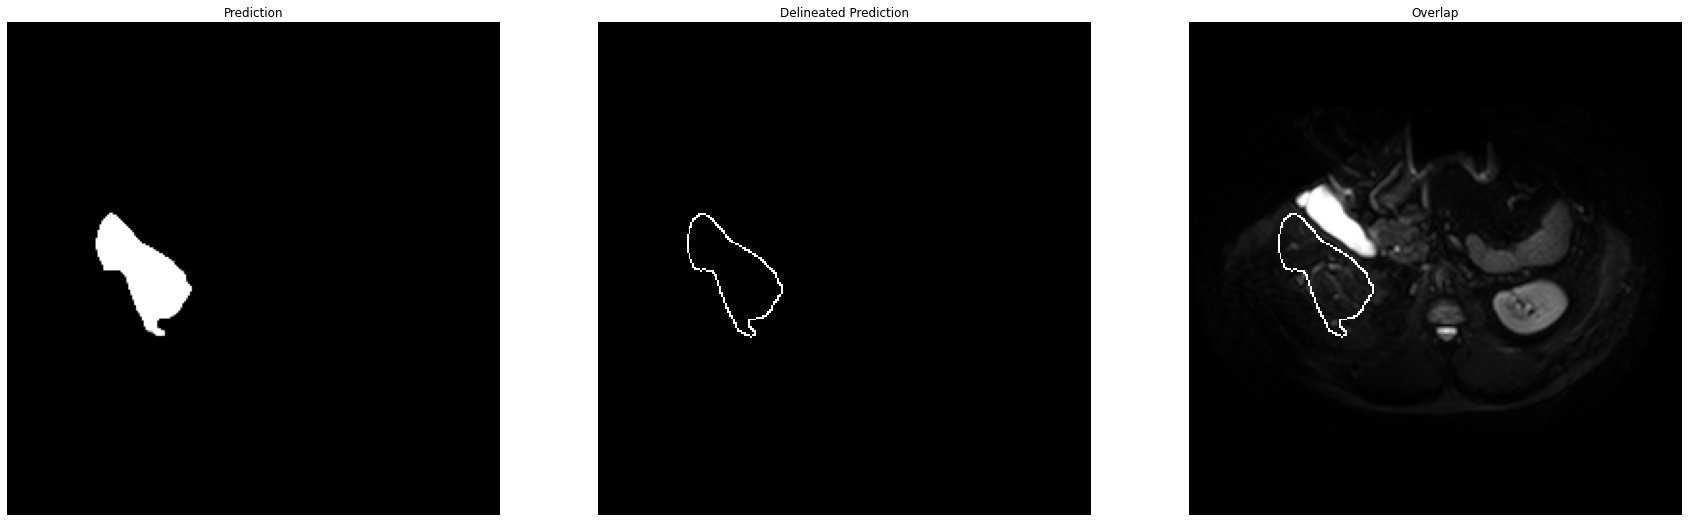

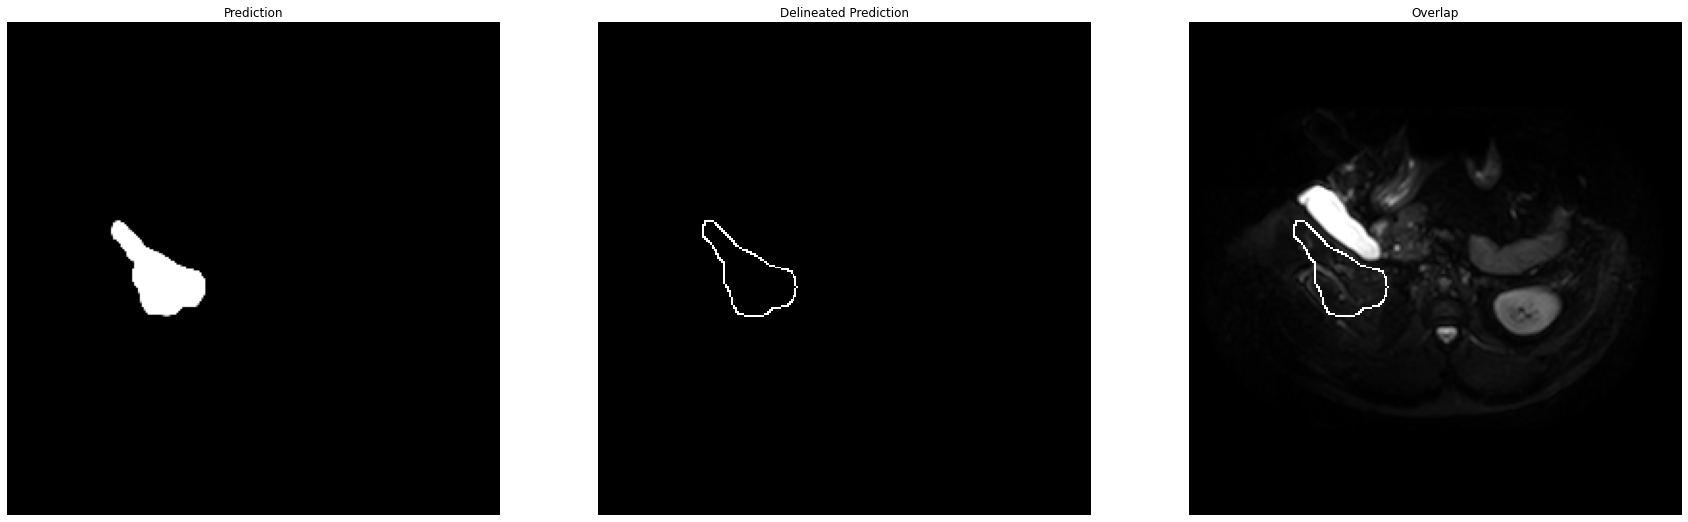

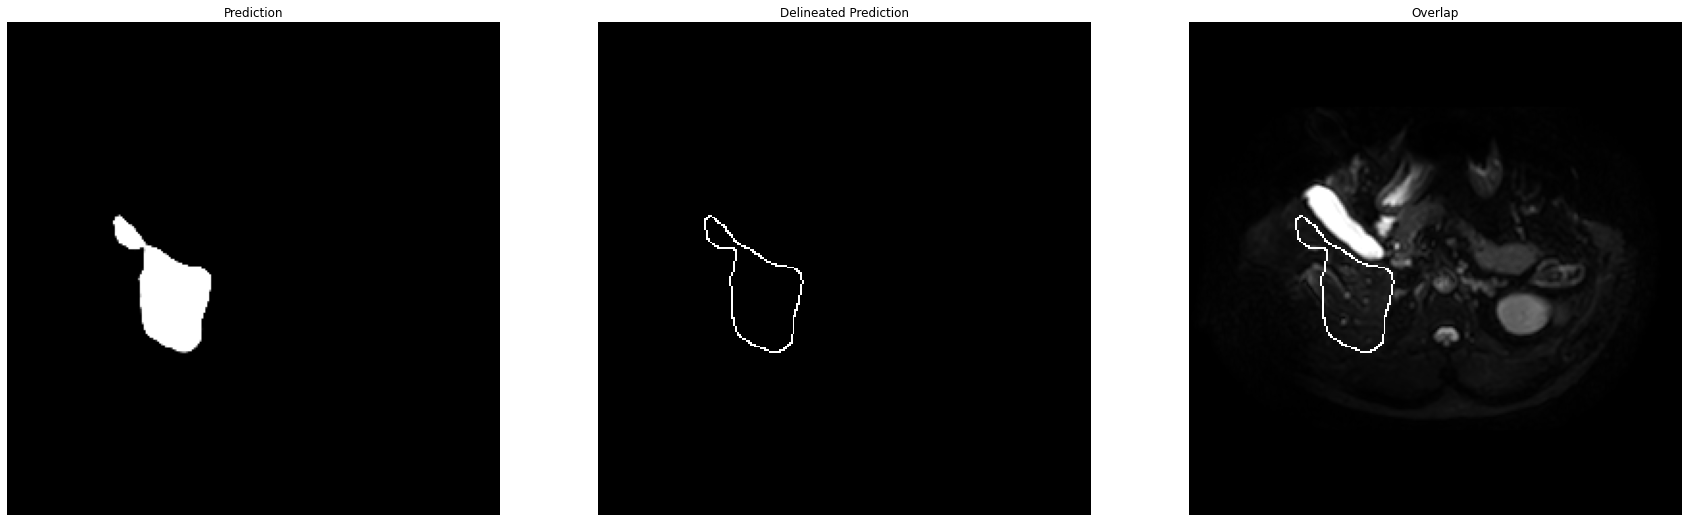

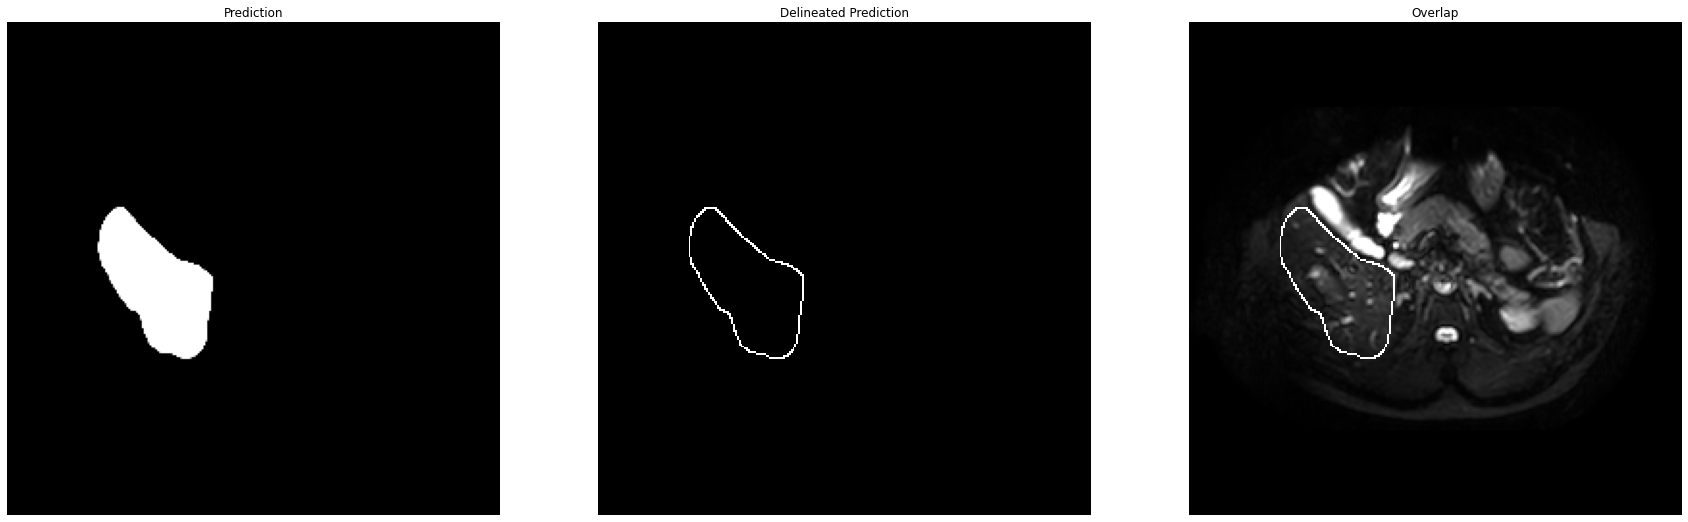

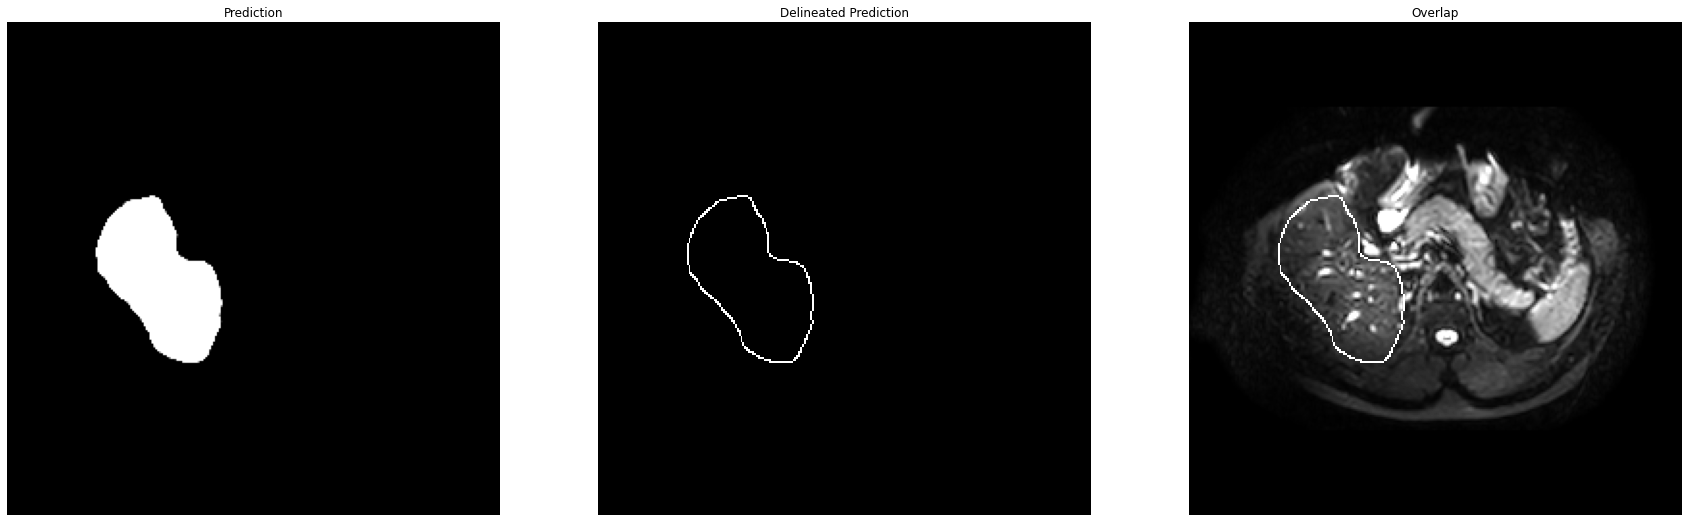

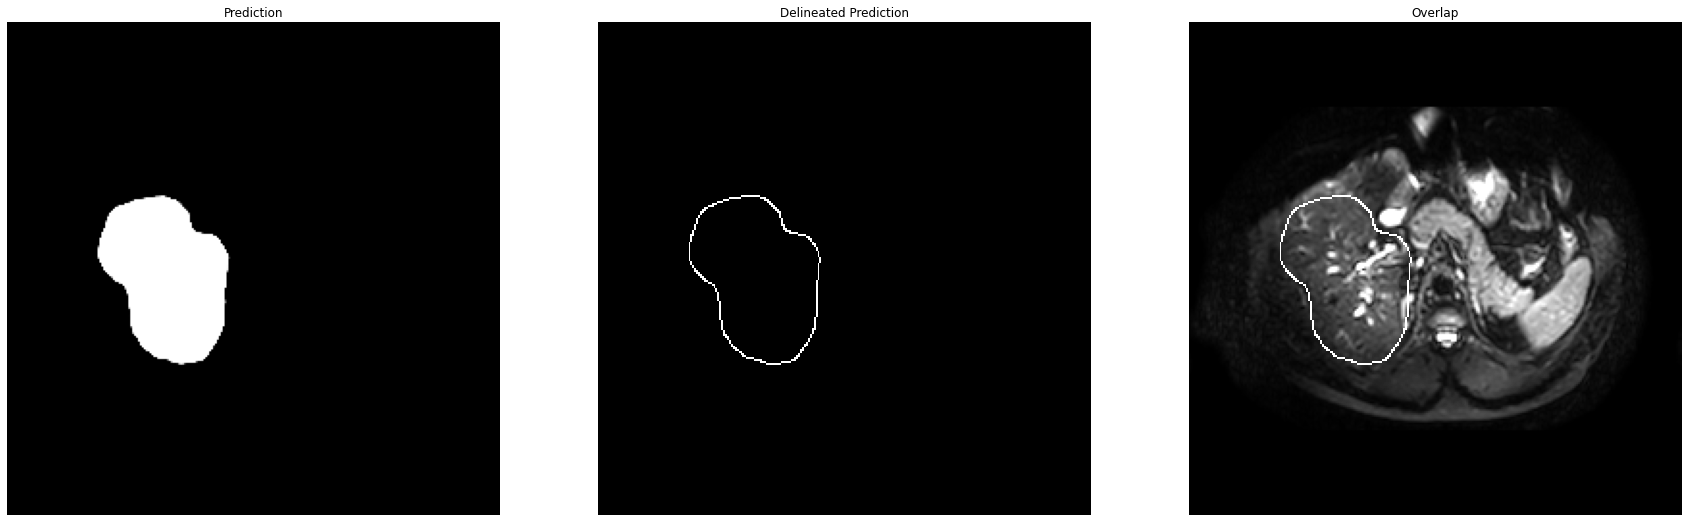

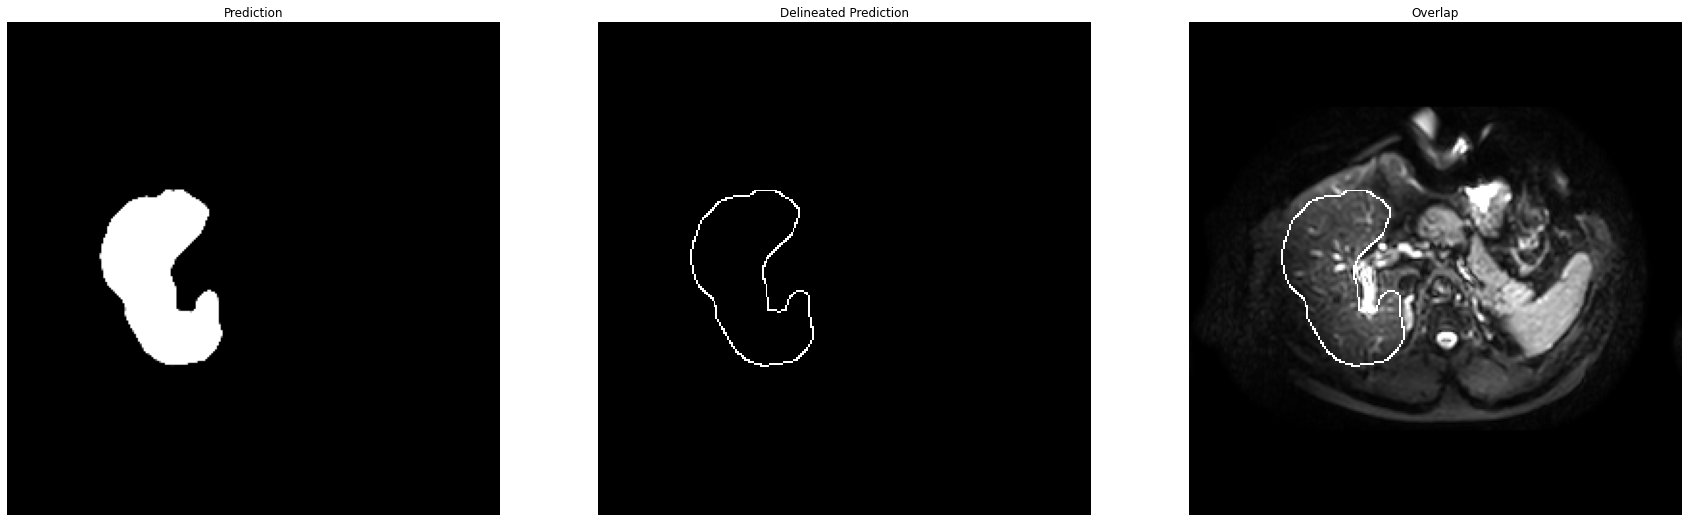

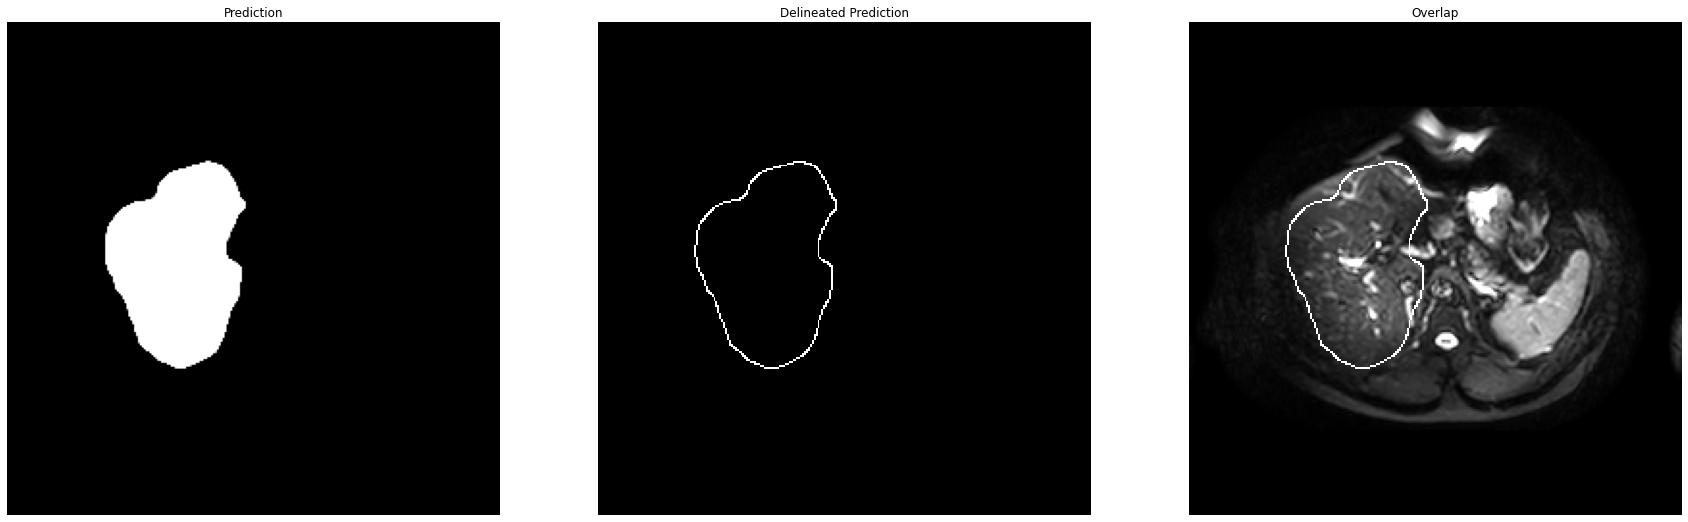

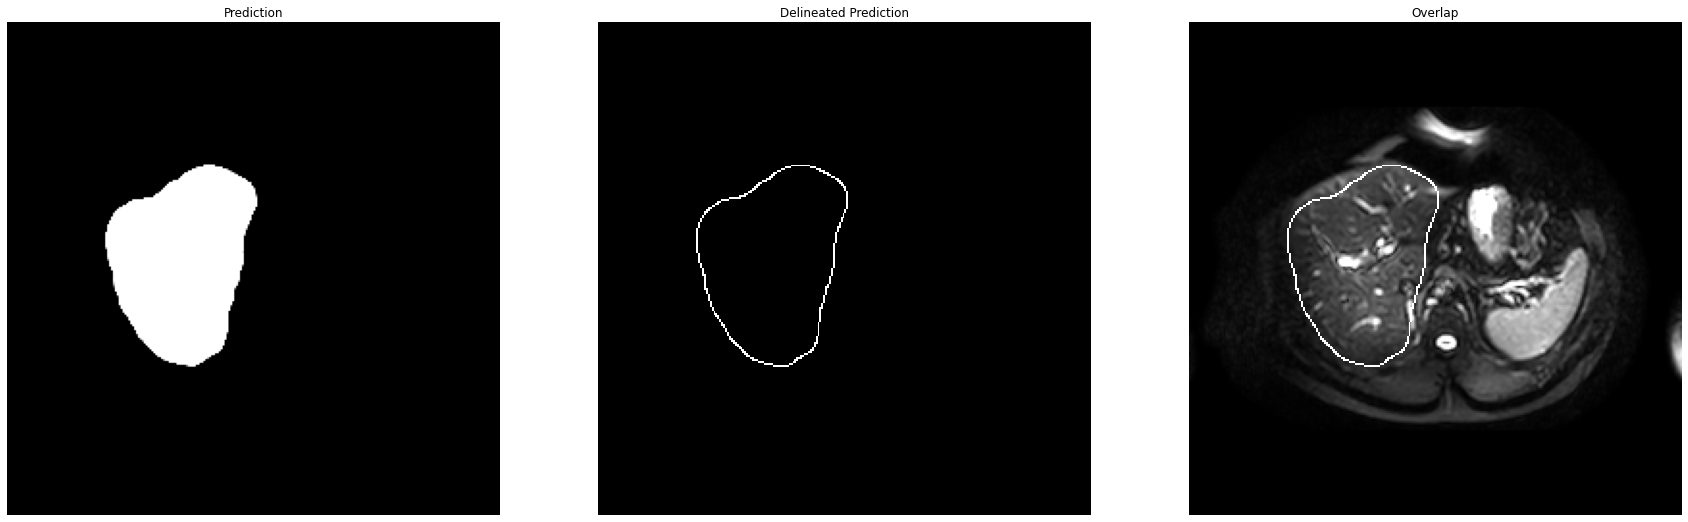

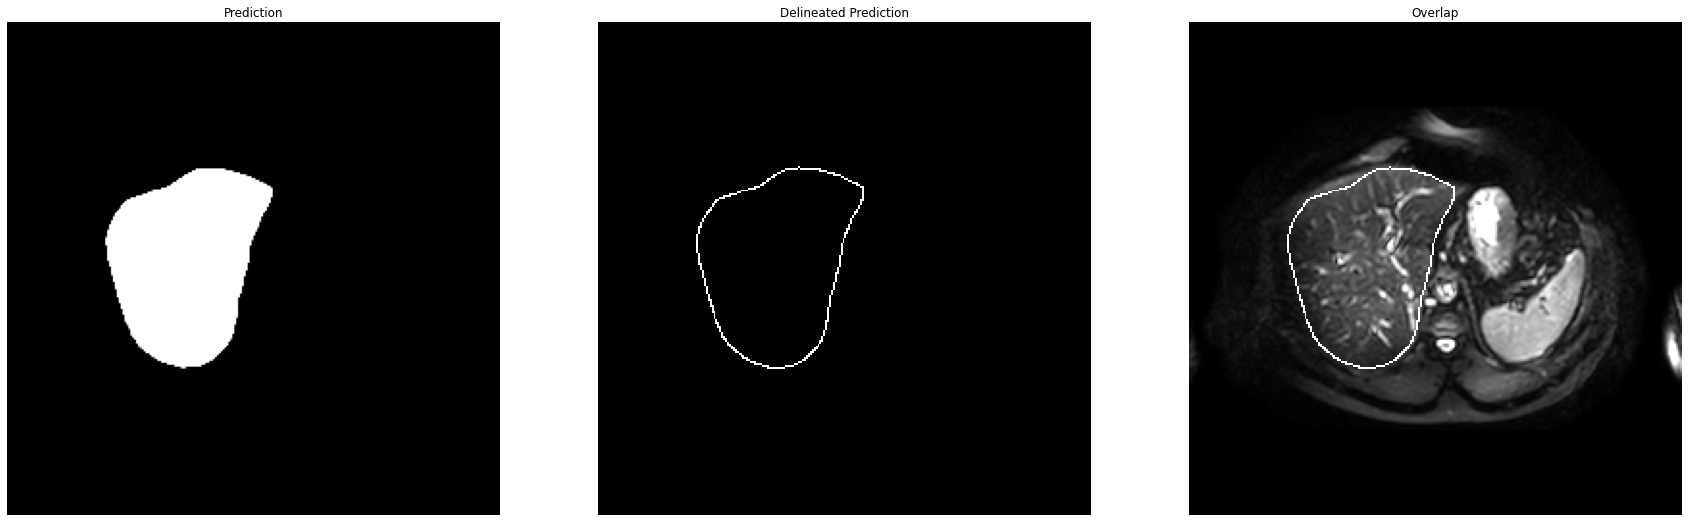

In [73]:
for i in range(15):
    show_dil(images[i], labels[i], pred[i])

## Augmentations 

In [ ]:
print(config['train_dataloader']['data_aug']['shear_range'])

train_transforms = torchvision.transforms.Compose([
#             mt_transforms.RandomRotation((10)), # random rotation
#             mt_transforms.RandomAffine(0, (0.05, 0.05)), # shift
            mt_transforms.RandomAffine(0, shear=(5,5)), # shear
            HistogramClipping(),
            RangeNorm(),
            mt_transforms.ToTensor(),
        ])

ext_transforms = torchvision.transforms.Compose([
#             mt_transforms.RandomRotation(40), # random rotation
#             mt_transforms.RandomAffine(0, (0.5,0.5)), # shift
            mt_transforms.RandomAffine(0, shear=(20,20)), # shear
            HistogramClipping(),
            RangeNorm(),
            mt_transforms.ToTensor(),
        ])

transforms = torchvision.transforms.Compose([
            HistogramClipping(),
            RangeNorm(),
            mt_transforms.ToTensor(),
        ])

dataset = MRI2DSegmentationDataset([filename_pairs[30]],transform=transforms, slice_filter_fn=slice_filtering)
dataloader = DataLoader(dataset, batch_size=20, shuffle=False, collate_fn=mt_datasets.mt_collate)

datasetaug = MRI2DSegmentationDataset([filename_pairs[30]],transform=train_transforms, slice_filter_fn=slice_filtering,)
dataloaderaug = DataLoader(datasetaug, batch_size=20, shuffle=False, collate_fn=mt_datasets.mt_collate)

datasetext = MRI2DSegmentationDataset([filename_pairs[30]],transform=ext_transforms, slice_filter_fn=slice_filtering,)
dataloaderext = DataLoader(datasetext, batch_size=20, shuffle=False, collate_fn=mt_datasets.mt_collate)

# vis_batch(dataloaderext) #(-7)

In [ ]:
for batch1 in dataloader:
    images, labels = batch1['input'], batch1['gt']
for batch2 in dataloaderaug:
    imgaug, labelaug = batch2['input'], batch2['gt']
for batch3 in dataloaderext:
    imgext, labelext = batch3['input'], batch3['gt']

# print(images[10].shape)
# print(images[10].squeeze(0).shape)

plt.imshow(ndimage.rotate(images[10].squeeze(0),90), cmap='gray')
plt.title('normal')
plt.axis('off')
plt.show()

plt.imshow(ndimage.rotate(imgaug[10].squeeze(0),90), cmap='gray')
plt.title('5 degree shear')
plt.axis('off')
plt.show()

plt.imshow(ndimage.rotate(imgext[10].squeeze(0),90), cmap='gray')
plt.title('20 degree shear')
plt.axis('off')
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize = (12,6))

ax1.imshow(ndimage.rotate(images[10].squeeze(0),90), cmap='gray', interpolation='none')
ax1.imshow(ndimage.rotate(imgaug[10].squeeze(0),90), cmap='gray', interpolation='none', alpha=0.7)
ax1.set_title('Overlay')
ax1.axis('off')

plt.show()

# EXTRA

In [1]:
import numpy as np

# #liver2
unet_score = [0.9261, 0.9197, 0.8749, 0.9331, 0.9128]
segnet_score = [0.7459, 0.7612, 0.8657, 0.8440, 0.8730]

# # liver1
unet_score = [0.8634, 0.8570, 0.7945, 0.8580, 0.8528]
segnet_score = [0.8034, 0.8414, 0.7923, 0.8211, 0.7282]

# # test
# unet_score = [50,15,25,12,45,3,45,8,10,8,7,20,9,9,12]
# segnet_score = [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20]

print(len(unet_score))
print(len(segnet_score))

diff = [y - x for x, y in zip(segnet_score, unet_score)]
# diff = [y - x for x, y in zip(unet_score, segnet_score)]
print(diff)

5
5
[0.05999999999999994, 0.015599999999999947, 0.0021999999999999797, 0.03689999999999993, 0.12460000000000004]


In [43]:
d_bar = np.mean(diff)
print(d_bar)

sigma2 = np.var(diff)
print(sigma2)

n1 = 999 # training data points/slices
n2 = 135 # testing data points/slices
n = 999+135 # total

sigma2_mod = sigma2 * (1/n + n2/n1)
print(sigma2_mod)

t_static = d_bar / np.sqrt(sigma2_mod)
print(t_static)

from scipy.stats import t

Pvalue = ((1-t.cdf(t_static, n-1))*200)
print()
print(Pvalue)

0.07839826839826841
0.0012941305447798927
0.0001760237146446172
5.909093740304308

4.5452239749721457e-07


In [2]:
from scipy.stats import ttest_ind

# import numpy as np
# week1 = np.genfromtxt("week1.csv",  delimiter=",")
# week2 = np.genfromtxt("week2.csv",  delimiter=",")
# print(week1)
# print("week2 data :-\n")
# print(week2)

week1_mean = np.mean(unet_score)
week2_mean = np.mean(segnet_score)
print("week1 mean value:",week1_mean)
print("week2 mean value:",week2_mean)

week1_std = np.std(unet_score)
week2_std = np.std(segnet_score)

print("week1 std value:",week1_std)
print("week2 std value:",week2_std)

ttest,pval = ttest_ind(unet_score,segnet_score)
print('ttest', ttest)
print("p-value",pval)

if pval <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

week1 mean value: 0.84514
week2 mean value: 0.79728
week1 std value: 0.025544283117754543
week2 std value: 0.038336061352204694
ttest 2.0778453391342997
p-value 0.07135376292742884
we accept null hypothesis


In [4]:
diff = week1_mean-week2_mean
print(diff)

0.09536000000000011


In [5]:
#Import required libraries
#import kaggle
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")# To download the dataset

df_pima = pd.read_csv('diabetes.csv')
X = df_pima.drop('Outcome', axis=1)
y = df_pima['Outcome']

RFC_score = []
SVM_score = []

for random_state in [42, 193]:
    # Splitting the dataset into train and test set
    #random_state = random.randint(100, 10000)
    #print(random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= random_state)
    
    # number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # number of features at every split
    max_features = ['auto', 'sqrt']# max depth
    max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
    max_depth.append(None)
    # create random grid
    random_grid = {
     'n_estimators': n_estimators,
     'max_features': max_features,
     'max_depth': max_depth
     }
    # Random search of parameters
    rfc_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    # Fit the model
#     rfc_random.fit(X_train, y_train)# print results
#     best_params = rfc_random.best_params_rfc = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
#                                  max_depth=best_params['max_depth'],
#                                  max_features=best_params['max_features'], 
#                                  random_state=42).fit(X_train,y_train);
#     RFC_score.append(rfc.score(X_test, y_test))
    
    
    ##Train SVM 
    random_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]}
    svm_random = RandomizedSearchCV(estimator = svm.SVC(kernel='rbf'),
                                    param_distributions = random_grid_svm, 
                                    n_iter = 100, cv = 3, verbose=0,
                                    random_state=42, n_jobs = -1)
    svm_random.fit(X_train, y_train)
    
    best_params = svm_random.best_params_
    
    SVM_model = svm.SVC(kernel='rbf',C = best_params['C'],
              gamma=best_params['gamma'], random_state=42).fit(X_train,y_train);
    
    SVM_score.append(SVM_model.score(X_test, y_test))
    
    print(SVM_score)
#     print('Iteration {}'.format(i))
#     print('The accuracy of SVM model is {}'.format(round(SVM_model.score(X_test, y_test),2)*100))
#     print('The accuracy of Random Forest model is {}'.format(round(rfc.score(X_test, y_test),2)*100))
#     print('-'*30)

[0.7056277056277056]
[0.7056277056277056, 0.7575757575757576]


In [6]:
diff = [y - x for y, x in zip([0.82, 0.80], SVM_score)]#Comopute the mean of differences
d_bar = np.mean(diff)#compute the variance of differences
print(d_bar)
sigma2 = np.var(diff)#compute the number of data points used for training 
print(sigma2)
n1 = len(y_train)#compute the number of data points used for testing 
print(n1)
n2 = len(y_test)#compute the total number of data points
print(n2)
n = len(y)#compute the modified variance
print(n)
sigma2_mod = sigma2 * (1/n + n2/n1)#compute the t_statict_static =  d_bar / np.sqrt(sigma2_mod)from scipy.stats import t#Compute p-value and plot the results 
print(sigma2_mod)
Pvalue = ((1 - t.cdf(t_static, n-1))*2)
Pvalue

0.07839826839826841
0.0012941305447798927
537
231
768
0.0005583780934562626


9.577104965741157e-05

In [41]:
## Import the packages
import numpy as np
from scipy import stats


## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.

print()

## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

print()
print('--eigen values--')
print()

from scipy import stats

unet_score = [0.9261, 0.9197, 0.8749, 0.9331, 0.9128]
segnet_score = [0.7459, 0.7612, 0.8657, 0.8440, 0.8730]

# t2, p2 = stats.ttest_ind(unet_score, segnet_score, permutations=1000)
# print(t2)
# print(p2)


stats.ttest_ind(unet_score, segnet_score)

t = 6.474656698850898
p = 4.326784414310225e-06

t = 6.474656698850897
p = 4.326784414367157e-06

--eigen values--



Ttest_indResult(statistic=3.322771123111419, pvalue=0.010496691806914291)

In [23]:
# unet_score = [0.9261, 0.9197, 0.8749, 0.9331, 0.9128]
# segnet_score = [0.7459, 0.7612, 0.8657, 0.8440, 0.8730]

unet_score = [0.8634, 0.8570, 0.7945, 0.8580, 0.8528]
segnet_score = [0.8034, 0.8414, 0.7923, 0.8211, 0.7282]

In [24]:
w, p= stats.wilcoxon(unet_score, segnet_score, alternative='greater')
print(w, p)

w, p= stats.wilcoxon(unet_score, segnet_score, mode='exact')
print(w, p)

15.0 0.03125
0.0 0.0625


In [13]:
import numpy as np
from scipy import stats

unet_score = [0.8634, 0.8570, 0.7945, 0.8580, 0.8528]
transf_score = [0.8566, 0.8552, 0.104, 0.8638, 0.8559]

stats.ttest_ind(unet_score, transf_score)

Ttest_indResult(statistic=0.9122215304366711, pvalue=0.38831451137018413)